===================================================
### Code developed by: Vinicius Luiz Santos Silva

### Contact: v.santos-silva19@imperial.ac.uk
===================================================

In [1]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${IPython.notebook.notebook_name}'`)

<IPython.core.display.Javascript object>

In [2]:
notebookName='WGAN-GP-training_4'
notebookName

'WGAN-GP-training_4'

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# Constants


## Load data

In [6]:
# Mesh size
nl = 10
nc = 10
print('Grid: ', nl, 'x',nc)

Grid:  10 x 10


In [7]:
import joblib
#joblib.dump(pca_compress, "pca_compress_15.pkl") 
#np.savetxt('X_train_1D.csv', X_train_1D, delimiter=',') 
#np.savetxt('X_train_pca.csv', X_train_pca, delimiter=',') 
#np.savetxt('times.csv', times, delimiter=',') 
#with open('groups.txt','w') as f:
#    f.writelines([g + '\n' for g in groups])

#...
pca_compress = joblib.load("/content/drive/MyDrive/masters/small_dataset/pca_compress_15.pkl") 
X_train_compressed = np.loadtxt('/content/drive/MyDrive/masters/small_dataset/X_train_pca.csv', delimiter=',') 

X_train_1D = np.loadtxt('/content/drive/MyDrive/masters/small_dataset/X_train_1D.csv', delimiter=',') 
times  = np.loadtxt('/content/drive/MyDrive/masters/small_dataset/times.csv', delimiter=',') 
with open('/content/drive/MyDrive/masters/small_dataset/groups.txt') as f:
    groups = [g.strip() for g in f.readlines()]

# PCA recovered
X_recovered = pca_compress.inverse_transform(X_train_compressed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


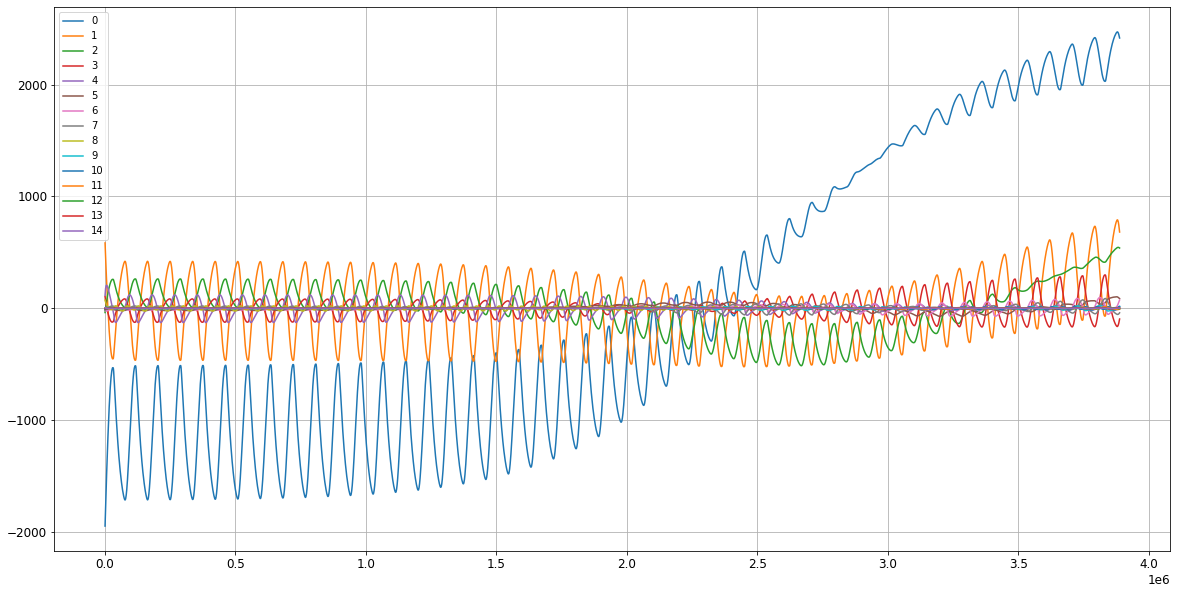

In [8]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(times, X_train_compressed);
ax.grid()
ax.legend(range(15))

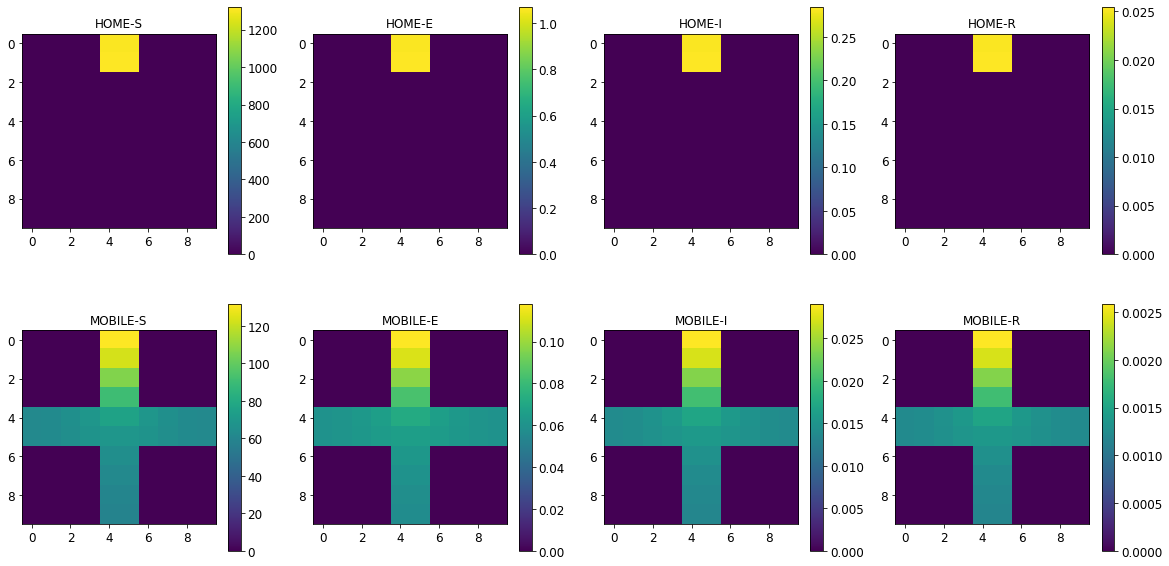

In [9]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_train_1D.reshape(len(times),len(groups),nl,nc)[100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

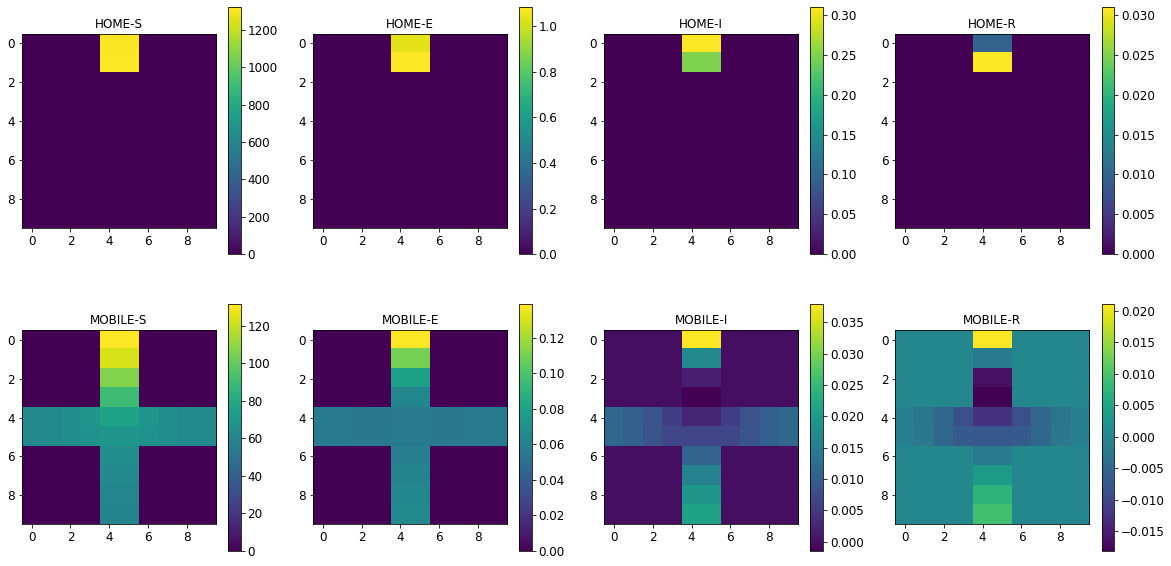

In [10]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_recovered.reshape(len(times),len(groups),nl,nc)[100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

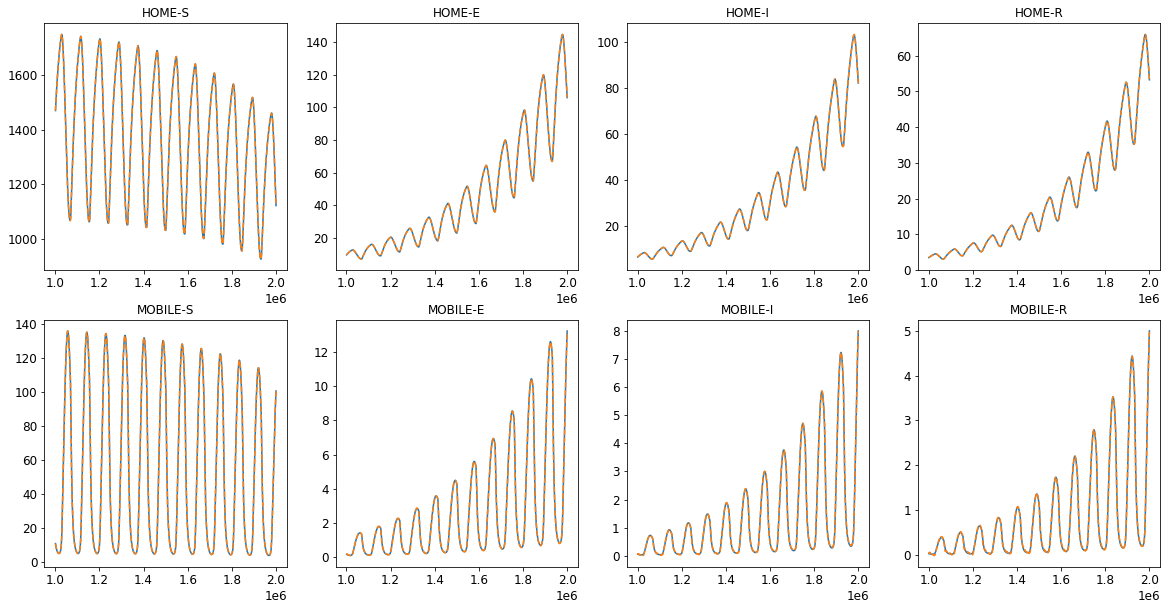

In [11]:


fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times[1000:2000], X_train_1D[1000:2000,i*nl*nc+4])
    ax.flatten()[i].plot(times[1000:2000], X_recovered[1000:2000,i*nl*nc+4],'--')
    ax.flatten()[i].set_title(group)

## Prepare data

In [12]:
codings_size = X_train_compressed.shape[1]
X_train_compressed.shape

(3888, 15)

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_compressed)*2 -1 
np.allclose(X_train_compressed, scaler.inverse_transform((X_train_scaled+1)/2))

True

In [14]:
def concat_timesteps(X_train, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train) - ntimes*step):
        X_train_concat.append(X_train[i:i+ntimes*step:step])
    return np.array(X_train_concat)

In [15]:
ntimes = 9 # Consecutive times for the GAN
step = 10 # step between times

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)
print(X_train_concat.shape[0])
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )

3798


(3798, 9, 15)


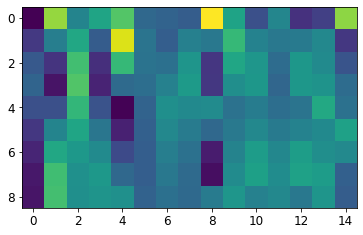

In [16]:
print(X_train_concat.shape)
plt.imshow(X_train_concat[0, :, :])

## Train the GAN

In [17]:
BATCH_SIZE = 256
latent_space = 100

# Create a tensorflow dataset and split it into batches
print(np.shape(X_train_concat))
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], 9, 15, 1).astype('float32')
print(np.shape(train_dataset))
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
print(len(X_train_concat))
train_dataset = train_dataset.shuffle(len(X_train_concat))
train_dataset = train_dataset.batch(BATCH_SIZE)
print(type(train_dataset))
for data in train_dataset:
    print(data)
    break

(3798, 9, 15)
(3798, 9, 15, 1)
3798
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
tf.Tensor(
[[[[-8.79054010e-01]
   [ 4.03950810e-01]
   [-5.92348166e-03]
   ...
   [ 1.06261142e-01]
   [ 1.26671374e-01]
   [-4.45565015e-01]]

  [[-8.65514517e-01]
   [ 3.63228410e-01]
   [ 1.05706798e-02]
   ...
   [-2.45331138e-01]
   [-3.54657657e-02]
   [-3.24289083e-01]]

  [[-6.99445367e-01]
   [-5.42886183e-02]
   [ 1.62183210e-01]
   ...
   [-1.78383768e-01]
   [-2.08311796e-01]
   [-2.25865021e-01]]

  ...

  [[-6.02899373e-01]
   [-2.75358766e-01]
   [ 2.33549133e-01]
   ...
   [-2.07298905e-01]
   [-1.32871484e-02]
   [ 1.22585610e-01]]

  [[-7.44874477e-01]
   [ 7.59311989e-02]
   [ 1.08493514e-01]
   ...
   [ 8.36447440e-03]
   [-5.24514057e-02]
   [ 6.30831718e-02]]

  [[-8.39503825e-01]
   [ 3.09310585e-01]
   [ 2.57468689e-02]
   ...
   [ 1.62455782e-01]
   [ 3.56030799e-02]
   [-2.18849108e-01]]]


 [[[-3.61386210e-01]
   [-8.87617290e-01]
   [ 4.59062040e-01]
   ...
  

In [18]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(5*4*256, use_bias=False, input_shape=(latent_space,)))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((5, 4, 256)))

    model.add(keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (3, 3), strides=(1, 2), padding='same', use_bias=False))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(1, (1, 9), strides=(2, 2), padding='same', output_padding=[0,0], use_bias=False, activation='tanh'))

    return model

In [19]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5120)              512000    
_________________________________________________________________
layer_normalization (LayerNo (None, 5120)              10240     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5120)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 4, 128)         294912    
_________________________________________________________________
layer_normalization_1 (Layer (None, 5, 4, 128)         256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 4, 128)         0

(1, 9, 15, 1)


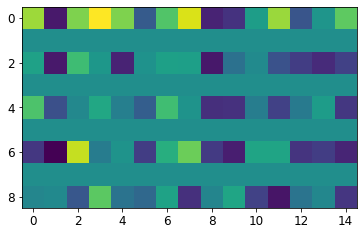

In [20]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0])

In [21]:
def make_critic_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[9, 15, 1]))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (5, 5), strides=(1, 2), padding='same'))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    # could swap dropout and flatten layers
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model

In [22]:
critic = make_critic_model()
critic.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 8, 64)          640       
_________________________________________________________________
layer_normalization_3 (Layer (None, 5, 8, 64)          128       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 5, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 4, 128)         204928    
_________________________________________________________________
layer_normalization_4 (Layer (None, 5, 4, 128)         256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 5, 4, 128)        

In [23]:
decision = critic(generated_image)
print (decision)

tf.Tensor([[-0.11021361]], shape=(1, 1), dtype=float32)


In [24]:
#gan = keras.models.Sequential([generator, discriminator])
wgan = keras.models.Sequential([generator, critic])

In [25]:
# This method returns a helper function to compute cross entropy loss
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# def discriminator_loss(real_output, fake_output):
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss

def critic_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    return fake_loss - real_loss


# def generator_loss(fake_output):
#     return cross_entropy(tf.ones_like(fake_output), fake_output)

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
critic_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

In [26]:
# The discriminator and the generator optimizers are different since we will train two networks separately.
# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
critic_optimizer = tf.keras.optimizers.Adam(1e-4)
# generator_optimizer = keras.optimizers.Adam(
#     learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
# critic_optimizer = keras.optimizers.Adam(
#     learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

In [27]:
def gradient_penalty(real, fake):
    """
    WGAN-GP uses gradient penalty instead of the weight
    clipping to enforce the Lipschitz constraint.
    """

    # alpha = tf.random.normal([self.BATCH_SIZE, self.n_var], mean=0.0, stddev=0.1)
    if real.shape[0]==BATCH_SIZE:
        alpha = tf.random.uniform(shape=[BATCH_SIZE, 1, 1, 1], minval=0., maxval=1.)
    else:
        alpha = tf.random.uniform(shape=[real.shape[0]%BATCH_SIZE, 1, 1, 1], minval=0., maxval=1.)
    interpolated = real + alpha * (fake - real)
    # print('interpolated ', np.shape(interpolated))

    with tf.GradientTape() as t:
        t.watch(interpolated)
        pred = critic(interpolated, training=True)
        # print('pred', np.shape(pred))
    grad = t.gradient(pred, interpolated)
    gradient_norm = tf.norm(grad)
    gp = tf.reduce_mean((gradient_norm - 1)**2)
    return gp
    # print('grad', np.shape(grad))
    # print('tf.square(grad)', tf.shape(tf.square(grad)))
    # print('tf.reduce_sum(tf.square(grad)', tf.shape(tf.reduce_sum(tf.square(grad))))
    # print('tf.sqrt(tf.reduce_sum(tf.square(grad)) + 1e-12)', tf.shape(tf.sqrt(tf.reduce_sum(tf.square(grad)) + 1e-12)))
    # norm = tf.sqrt(tf.reduce_sum(tf.square(grad)) + 1e-12)
    # print('norm', tf.shape(norm))


In [28]:
# We will reuse this seed overtime 
num_examples_to_generate = 5
seed = tf.random.normal([num_examples_to_generate, latent_space])

In [29]:
# logs to follow losses on tensorboard
#current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
generator_log_dir = './logs/' + 'WGAN-GP_4' + '/generator'
critic_log_dir = './logs/' + 'WGAN-GP_4' + '/critic'

generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)
critic_summary_writer = tf.summary.create_file_writer(critic_log_dir)

In [30]:
@tf.function
def train_G(batch):
    """
    The training routine for the generator
    """
    if batch.shape[0]==BATCH_SIZE:
        noise = tf.random.normal([BATCH_SIZE, latent_space], mean=0.0, stddev=0.1)
    else:
        noise = tf.random.normal([batch.shape[0]%BATCH_SIZE, latent_space], mean=0.0, stddev=0.1)

    with tf.GradientTape() as gen_tape:
        generated_data = generator(noise, training=True)
        fake_output = critic(generated_data, training=True)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # return tf.math.abs(gen_loss)
    # print('gen_loss', tf.shape(gen_loss))
    return gen_loss

In [31]:

@tf.function
def train_D(batch):
    """
    The training routine for the critic
    """
    if batch.shape[0]==BATCH_SIZE:
        noise = tf.random.normal([BATCH_SIZE, latent_space], mean=0.0, stddev=0.1)
    else:
        noise = tf.random.normal([batch.shape[0]%BATCH_SIZE, latent_space], mean=0.0, stddev=0.1)

    with tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = critic(batch, training=True)
        fake_output = critic(generated_data, training=True)

        disc_loss = critic_loss(real_output, fake_output)
        gp = gradient_penalty(batch, generated_data)
        # disc_loss += (self.critic_loss(real_output, fake_output) + gp*10.0)
        disc_loss += gp*10.0

    gradients_of_critic = disc_tape.gradient(disc_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))

    # return tf.math.abs(disc_loss)
    # print('disc_loss', tf.shape(disc_loss))
    # print('disc_slice', tf.slice(disc_loss, [0], [-1]))
    

    return disc_loss

In [32]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function
# def train_step(batch):
#     noise = tf.random.normal([BATCH_SIZE, latent_space])

#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         generated_images = generator(noise, training=True)

#         real_output = discriminator(batch, training=True)
#         fake_output = discriminator(generated_images, training=True)

#         gen_loss = generator_loss(fake_output)
#         disc_loss = discriminator_loss(real_output, fake_output)

#     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#     discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
#     generator_mean_loss(gen_loss)
#     discriminator_mean_loss(disc_loss)


In [33]:
# test_count = 0
# def test_f(test_count):
#   print('done')
#   test_count += 1
#   return test_count

# def train_test(test_count, epochs=10):
#   for epoch in range(epochs):
#     test_f(test_count)
#     test_count = test_f(test_count)
#     print(test_count)
    
#   return 1

# bla = train_test(test_count)




In [34]:
# def train(dataset, epochs, scaler, scaled, X_train, y_train,n_critic=5):
def train(dataset, epochs, n_critic=5):
    """
    Training the WGAN-GP
    """

    hist = []
    for epoch in range(epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch, epochs))

        for batch in dataset:

            for _ in range(n_critic):
              # train_D(batch, count_D)
              disc_loss = train_D(batch)
            critic_mean_loss(disc_loss)
            # print('critic_mean_loss', critic_mean_loss.numpy())

            


            gen_loss = train_G(batch)
            generator_mean_loss(gen_loss)
            # train_G(batch, count_G)

        with critic_summary_writer.as_default():
              tf.summary.scalar('loss', critic_mean_loss.result(), step=epoch)

        with generator_summary_writer.as_default():
            tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)

        # with critic_summary_writer.as_default():
        #     tf.summary.scalar('loss', critic_mean_loss.result(), step=epoch)

        hist.append([generator_mean_loss.result().numpy(), critic_mean_loss.result().numpy()])

        generator_mean_loss.reset_states()
        critic_mean_loss.reset_states()

        # print("critic", "{}: {:.6f}".format(critic.metrics_names[0], hist[-1][1]), end=' - ')
        # print("generator", "{}: {:.6f}".format(wgan.metrics_names[0], hist[-1][0]), end=' - ')    
        # print ('{:.0f}s'.format( time.time()-start))

        print("critic: {:.6f}".format(hist[-1][1]), end=' - ')
        print("generator: {:.6f}".format(hist[-1][0]), end=' - ')
        print('{:.0f}s'.format( time.time()-start))

        print('disc_numpy', disc_loss.numpy())
        print('gen_numpy', gen_loss.numpy())
        # Global variables are used below
        if epoch%1000 == 0: 
            # Plot generated data
            X_generated = scaler.inverse_transform((generator.predict(seed).reshape(num_examples_to_generate*ntimes,15)+1)/2)
            X_generated = pca_compress.inverse_transform(X_generated)
            X_generated = X_generated.reshape(num_examples_to_generate, ntimes, len(groups)*nl*nc)
            fig, ax = plt.subplots(num_examples_to_generate*2,len(groups), figsize=[20,num_examples_to_generate*5])
            for j in range(num_examples_to_generate):
                for i, group in enumerate(groups):
                    for k in range(0,10,10): 
                        ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
                for i, group in enumerate(groups):
                    im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
                    fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])
            plt.savefig('snapshot_images/town/'+'WGAN-GP_5_'+str(epoch)+'.jpeg')
            plt.show() 
            

            # Save model
            wgan.save('ganmodels/'+'WGAN-GP_5_'+str(epoch)+'.h5')
                        
    

            # plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[20,10])
            ax.plot(hist[100:])
            ax.legend(['loss_gen', 'loss_disc'])
            # ax.set_yscale('log')
            ax.grid()
            plt.savefig('snapshot_images/loss/'+'WGAN-GP_5_'+str(epoch)+'.jpeg')
            plt.show()

    return hist


In [35]:
# def train(dataset, epochs):
#     hist = []
#     for epoch in range(epochs):
#         start = time.time()
#         print("Epoch {}/{}".format(epoch + 1, epochs))   

#         for batch in dataset:
#             train_step(batch)
            
#         with generator_summary_writer.as_default():
#             tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)

#         with discriminator_summary_writer.as_default():
#             tf.summary.scalar('loss', discriminator_mean_loss.result(), step=epoch)
        
#         hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])

#         generator_mean_loss.reset_states()
#         discriminator_mean_loss.reset_states()
        
#         print("discriminator", "{}: {:.6f}".format(discriminator.metrics_names[0], hist[-1][1]), end=' - ')
#         print("generator", "{}: {:.6f}".format(gan.metrics_names[0], hist[-1][0]), end=' - ')    
#         print ('{:.0f}s'.format( time.time()-start))

#         # Global variables are used below
#         if epoch%1000 == 0: 
#             # Plot generated data
#             X_generated = scaler.inverse_transform((generator.predict(seed).reshape(num_examples_to_generate*ntimes,15)+1)/2)
#             X_generated = pca_compress.inverse_transform(X_generated)
#             X_generated = X_generated.reshape(num_examples_to_generate, ntimes, len(groups)*nl*nc)
#             fig, ax = plt.subplots(num_examples_to_generate*2,len(groups), figsize=[20,num_examples_to_generate*5])
#             for j in range(num_examples_to_generate):
#                 for i, group in enumerate(groups):
#                     for k in range(0,10,10): 
#                         ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
#                 for i, group in enumerate(groups):
#                     im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
#                     fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])
#             plt.show() 
                    
#             # Save model
#             gan.save('ganmodels/'+notebookName[:-6]+str(epoch)+'.h5')    
            
#             # plot loss
#             print('Loss: ')
#             fig, ax = plt.subplots(1,1, figsize=[20,10])
#             ax.plot(hist)
#             ax.legend(['loss_gen', 'loss_disc'])
#             ax.set_yscale('log')
#             ax.grid()
#             plt.show()
            
#     return hist


Epoch 0/10000
critic: 11013.633789 - generator: -0.346644 - 6s
disc_numpy 2464.038
gen_numpy -0.3696402


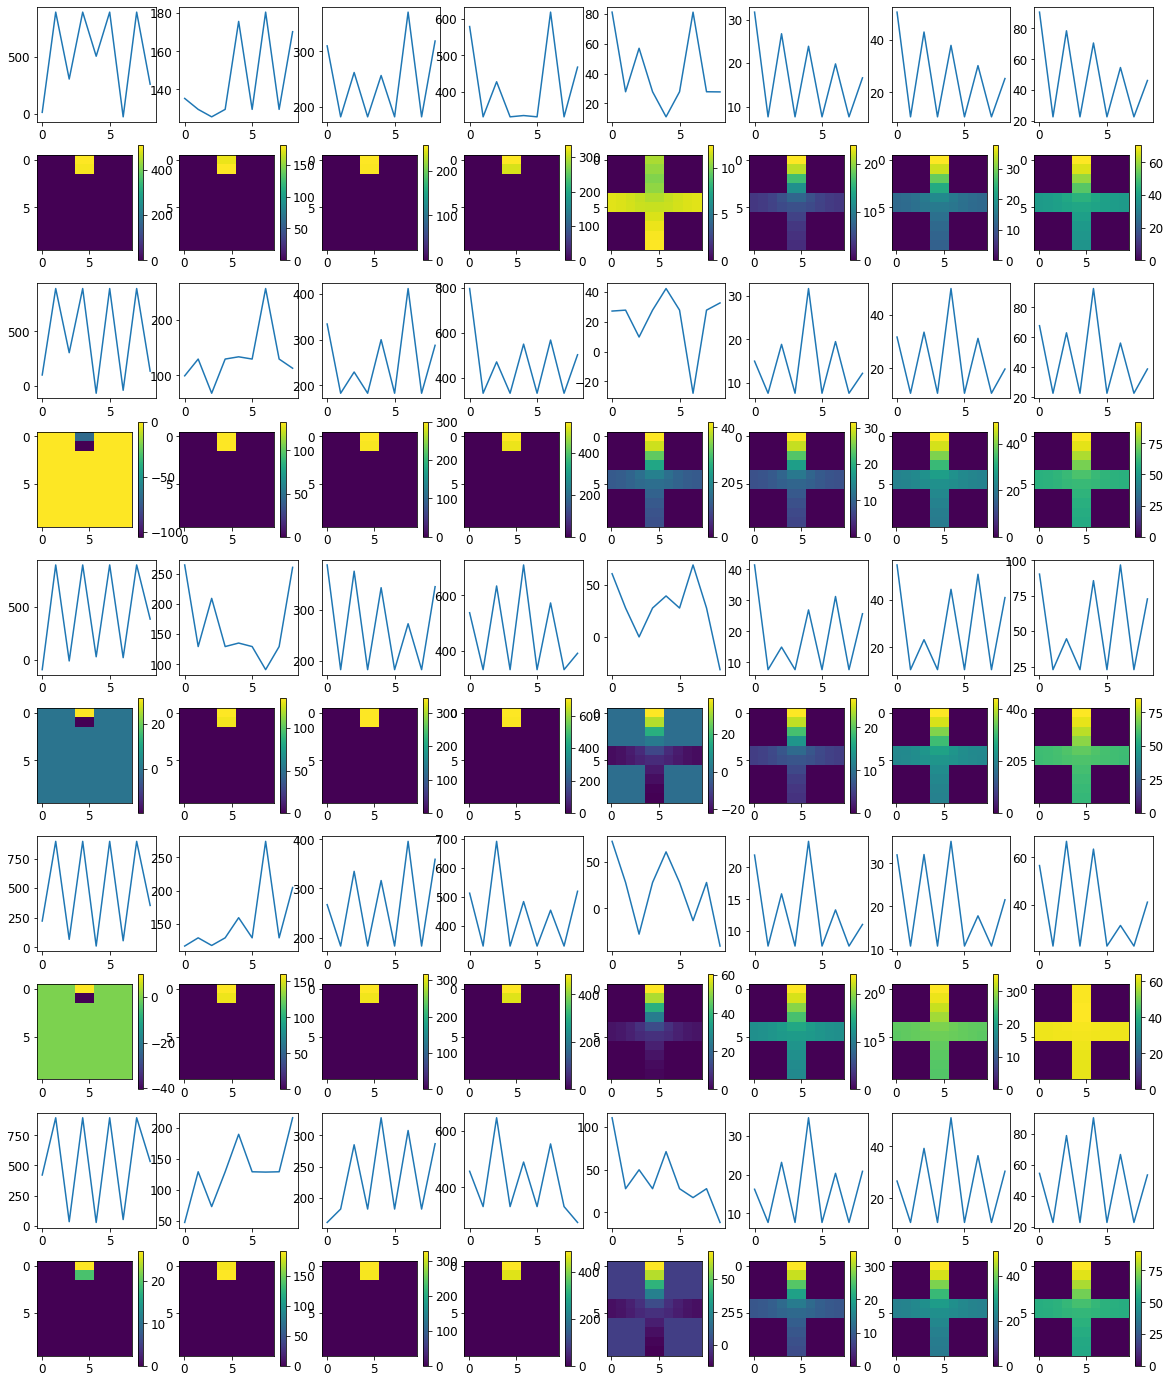

Loss: 


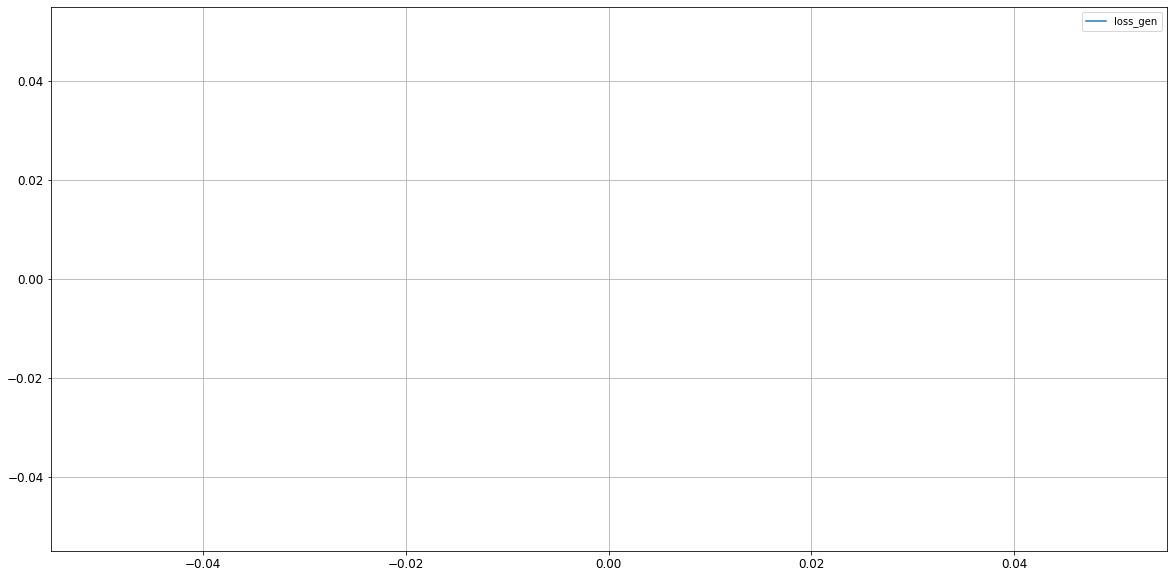

Epoch 1/10000
critic: 1998.351440 - generator: -0.457740 - 2s
disc_numpy 1236.9603
gen_numpy -0.48235834
Epoch 2/10000
critic: 1416.413208 - generator: -0.484896 - 2s
disc_numpy 1186.0417
gen_numpy -0.4741553
Epoch 3/10000
critic: 1137.613525 - generator: -0.551224 - 2s
disc_numpy 729.8624
gen_numpy -0.5524496
Epoch 4/10000
critic: 735.331665 - generator: -0.578152 - 2s
disc_numpy 513.2684
gen_numpy -0.56098545
Epoch 5/10000
critic: 554.693787 - generator: -0.591571 - 2s
disc_numpy 378.92194
gen_numpy -0.57095706
Epoch 6/10000
critic: 426.379059 - generator: -0.605117 - 2s
disc_numpy 332.3994
gen_numpy -0.67794156
Epoch 7/10000
critic: 454.166107 - generator: -0.607125 - 2s
disc_numpy 492.675
gen_numpy -0.6310348
Epoch 8/10000
critic: 459.329926 - generator: -0.635208 - 2s
disc_numpy 280.79138
gen_numpy -0.60914844
Epoch 9/10000
critic: 278.416168 - generator: -0.616947 - 2s
disc_numpy 189.47263
gen_numpy -0.6488513
Epoch 10/10000
critic: 198.664780 - generator: -0.612991 - 2s
disc_num

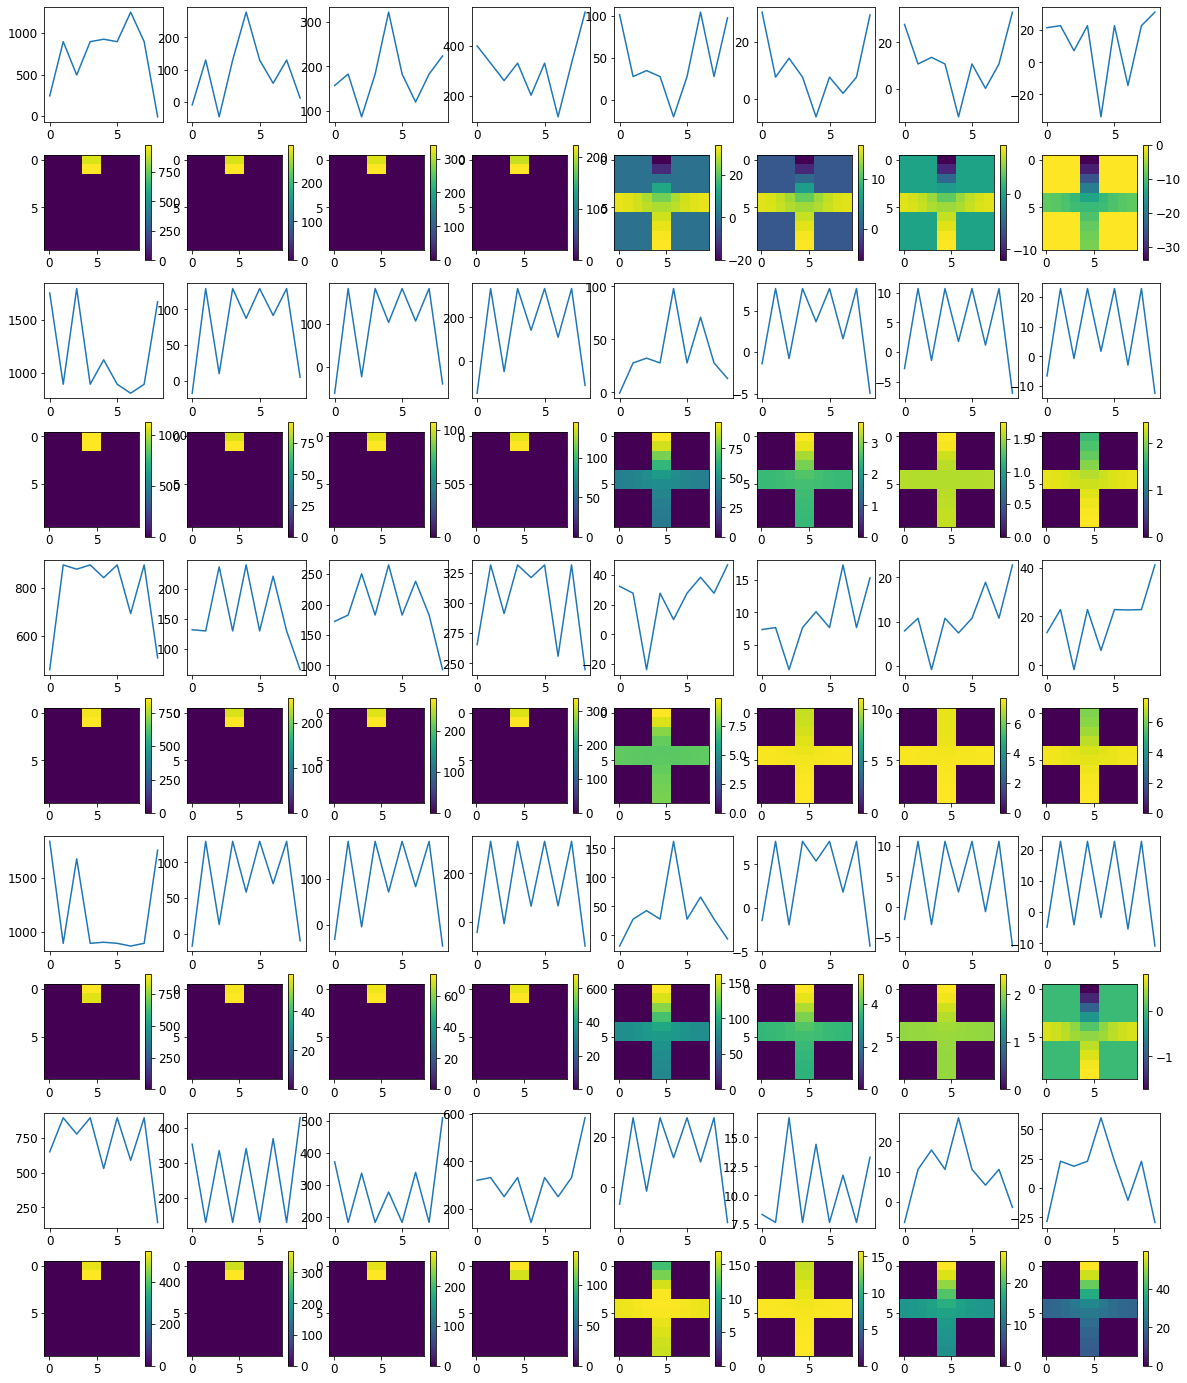

Loss: 


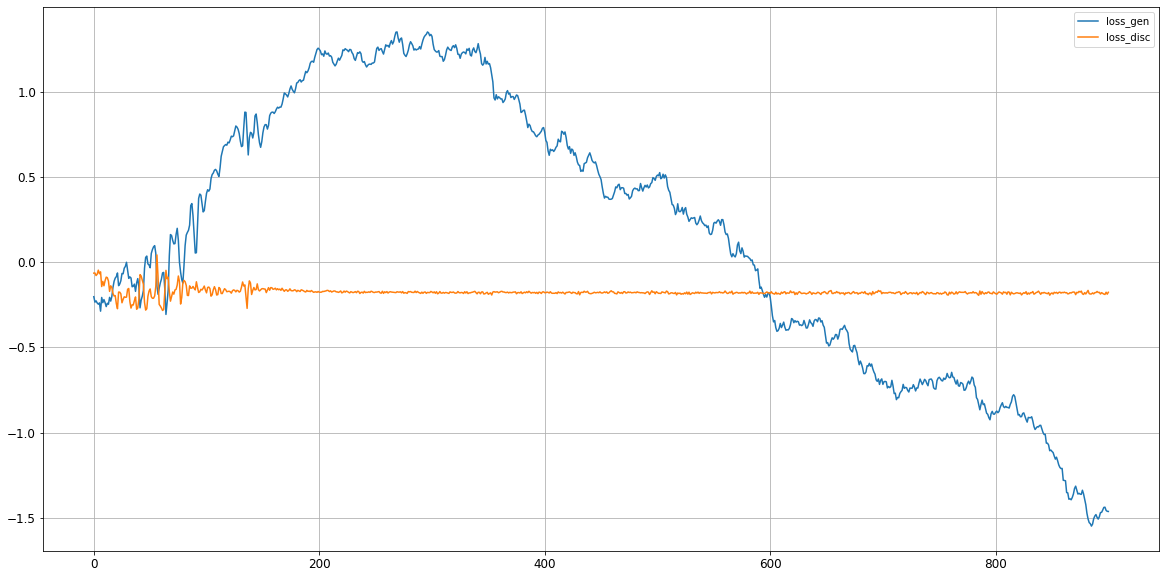

Epoch 1001/10000
critic: -0.184288 - generator: -1.459051 - 2s
disc_numpy -0.1848335
gen_numpy -1.522889
Epoch 1002/10000
critic: -0.182391 - generator: -1.507534 - 2s
disc_numpy -0.22015369
gen_numpy -1.5492129
Epoch 1003/10000
critic: -0.184196 - generator: -1.495066 - 2s
disc_numpy -0.15765107
gen_numpy -1.4913877
Epoch 1004/10000
critic: -0.180302 - generator: -1.499928 - 2s
disc_numpy -0.14056812
gen_numpy -1.5004759
Epoch 1005/10000
critic: -0.185389 - generator: -1.500851 - 2s
disc_numpy -0.2017617
gen_numpy -1.5235362
Epoch 1006/10000
critic: -0.198284 - generator: -1.522353 - 2s
disc_numpy -0.22705628
gen_numpy -1.527786
Epoch 1007/10000
critic: -0.181821 - generator: -1.524636 - 2s
disc_numpy -0.14638418
gen_numpy -1.5288209
Epoch 1008/10000
critic: -0.180942 - generator: -1.541133 - 2s
disc_numpy -0.15214786
gen_numpy -1.5567294
Epoch 1009/10000
critic: -0.182302 - generator: -1.507597 - 2s
disc_numpy -0.18199748
gen_numpy -1.508673
Epoch 1010/10000
critic: -0.178743 - gener

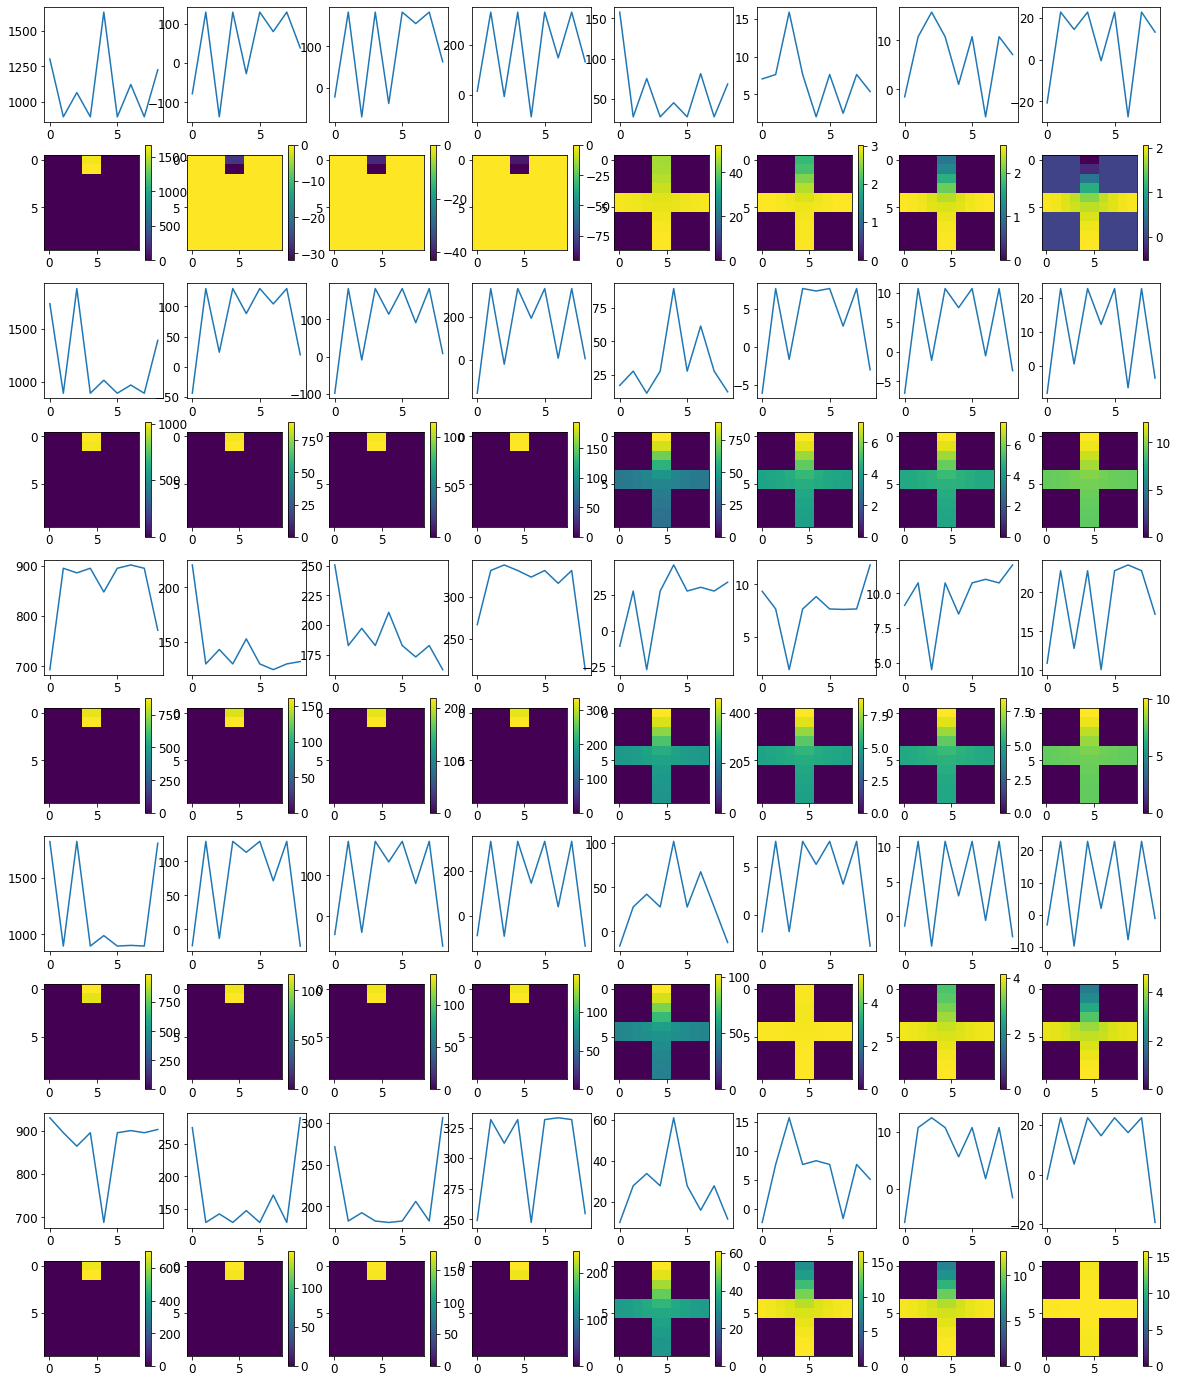

Loss: 


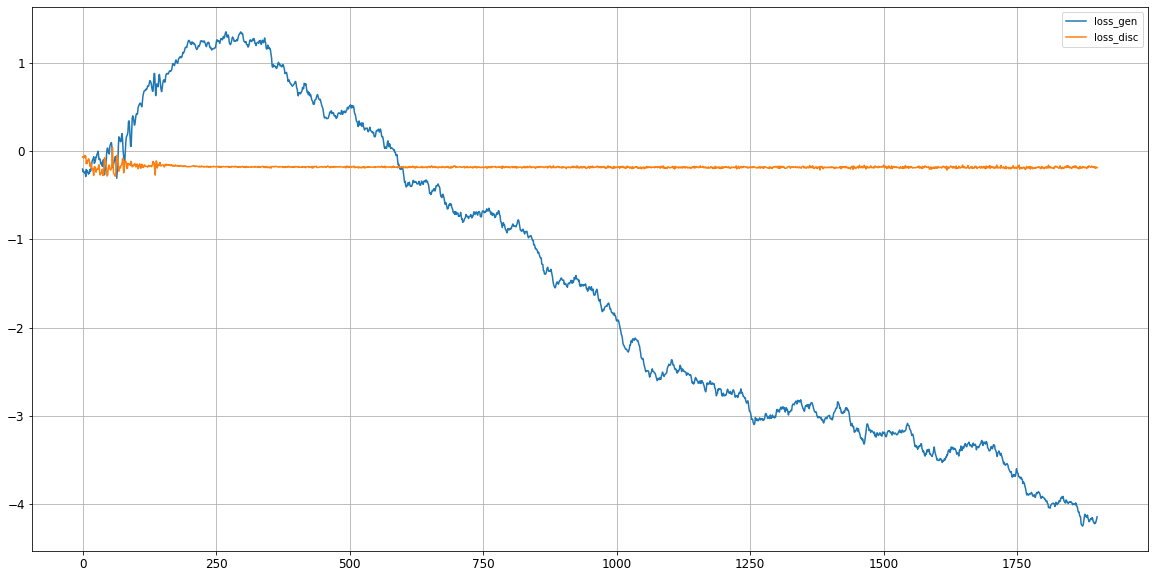

Epoch 2001/10000
critic: -0.207437 - generator: -4.178072 - 2s
disc_numpy -0.22806396
gen_numpy -4.179546
Epoch 2002/10000
critic: -0.183623 - generator: -4.203871 - 2s
disc_numpy -0.20613268
gen_numpy -4.2385826
Epoch 2003/10000
critic: -0.162637 - generator: -4.178280 - 2s
disc_numpy -0.11616108
gen_numpy -4.1742926
Epoch 2004/10000
critic: -0.185676 - generator: -4.166728 - 2s
disc_numpy -0.21862793
gen_numpy -4.166096
Epoch 2005/10000
critic: -0.186165 - generator: -4.172978 - 2s
disc_numpy -0.15833221
gen_numpy -4.222709
Epoch 2006/10000
critic: -0.199574 - generator: -4.173689 - 2s
disc_numpy -0.16839883
gen_numpy -4.2332296
Epoch 2007/10000
critic: -0.169768 - generator: -4.172601 - 2s
disc_numpy -0.2339344
gen_numpy -4.1801343
Epoch 2008/10000
critic: -0.193913 - generator: -4.162562 - 2s
disc_numpy -0.16257012
gen_numpy -4.2073956
Epoch 2009/10000
critic: -0.177555 - generator: -4.174339 - 2s
disc_numpy -0.13416204
gen_numpy -4.1936016
Epoch 2010/10000
critic: -0.188653 - gene

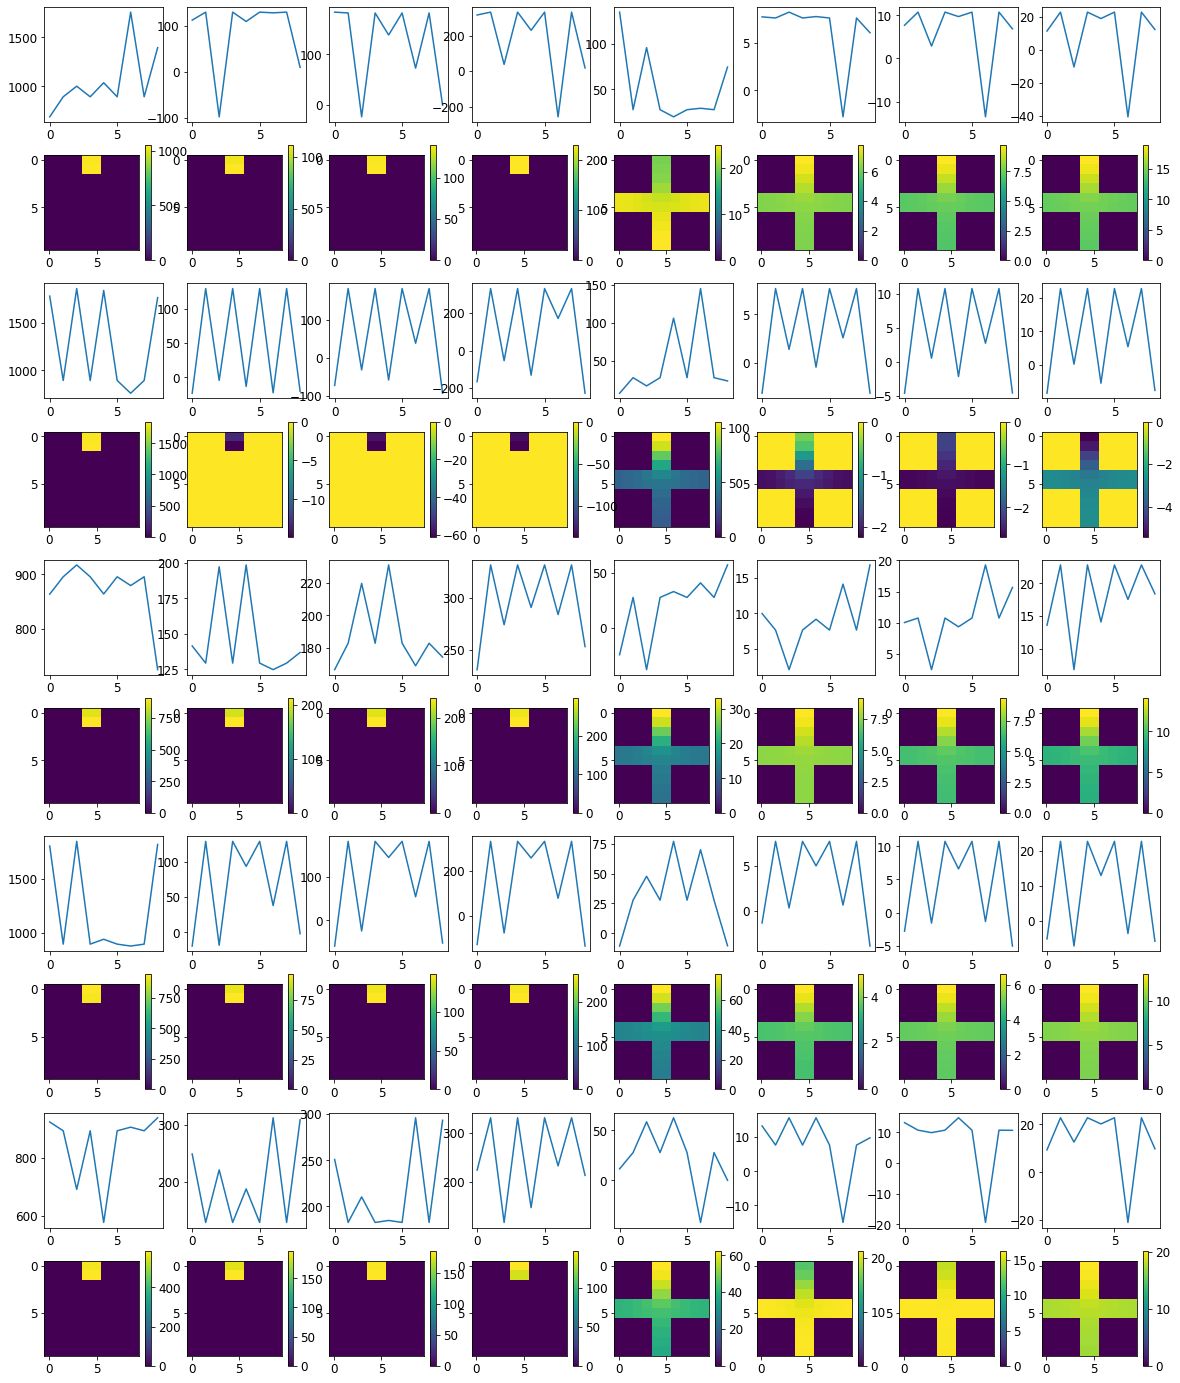

Loss: 


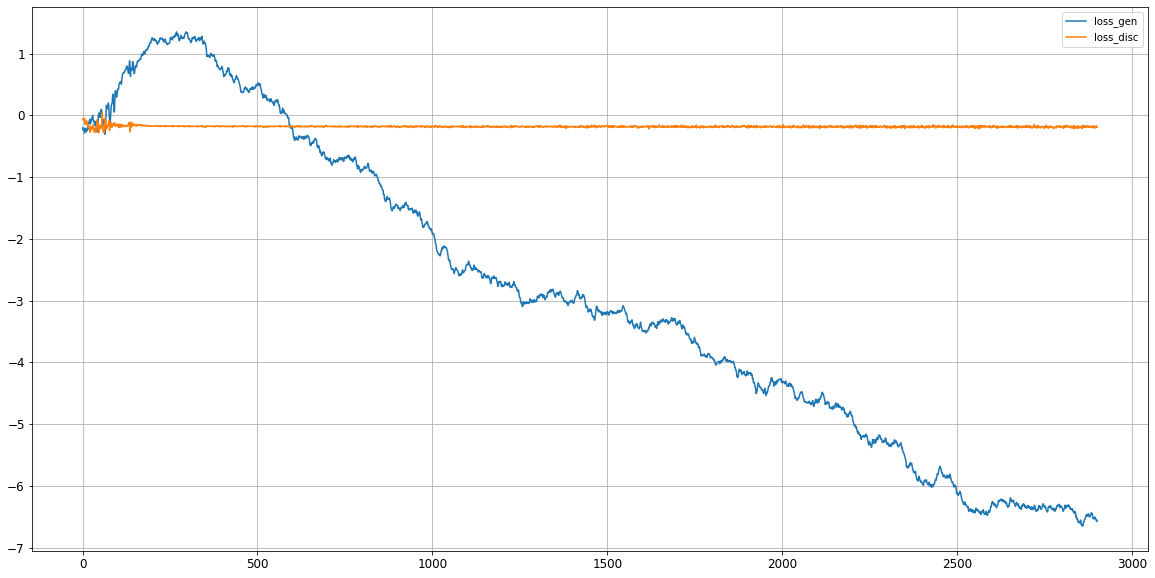

Epoch 3001/10000
critic: -0.189522 - generator: -6.601976 - 2s
disc_numpy -0.15237804
gen_numpy -6.666396
Epoch 3002/10000
critic: -0.182067 - generator: -6.644910 - 2s
disc_numpy -0.09850475
gen_numpy -6.7295356
Epoch 3003/10000
critic: -0.185343 - generator: -6.677471 - 2s
disc_numpy -0.18057579
gen_numpy -6.763669
Epoch 3004/10000
critic: -0.187326 - generator: -6.704537 - 2s
disc_numpy -0.18316326
gen_numpy -6.7371135
Epoch 3005/10000
critic: -0.180984 - generator: -6.722942 - 2s
disc_numpy -0.18390852
gen_numpy -6.707971
Epoch 3006/10000
critic: -0.185440 - generator: -6.729773 - 2s
disc_numpy -0.17831218
gen_numpy -6.731267
Epoch 3007/10000
critic: -0.204546 - generator: -6.719398 - 2s
disc_numpy -0.19843197
gen_numpy -6.7092934
Epoch 3008/10000
critic: -0.176766 - generator: -6.737985 - 2s
disc_numpy -0.14616208
gen_numpy -6.8115807
Epoch 3009/10000
critic: -0.165557 - generator: -6.739823 - 2s
disc_numpy -0.10535699
gen_numpy -6.7896194
Epoch 3010/10000
critic: -0.180421 - gene

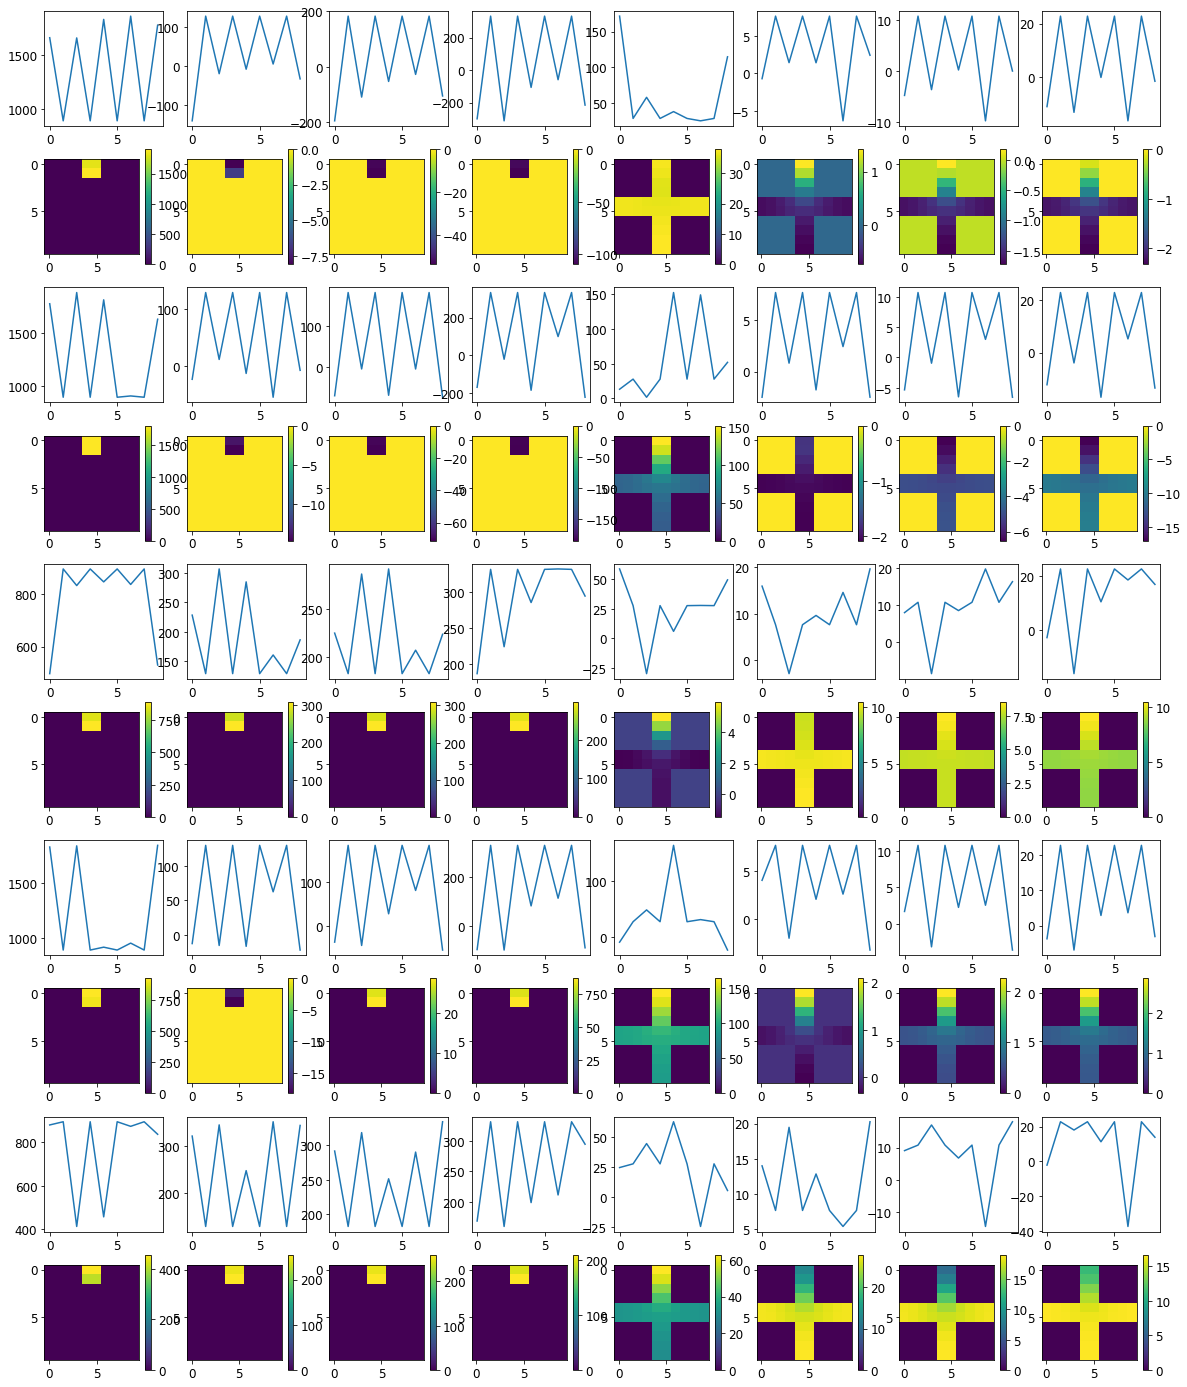

Loss: 


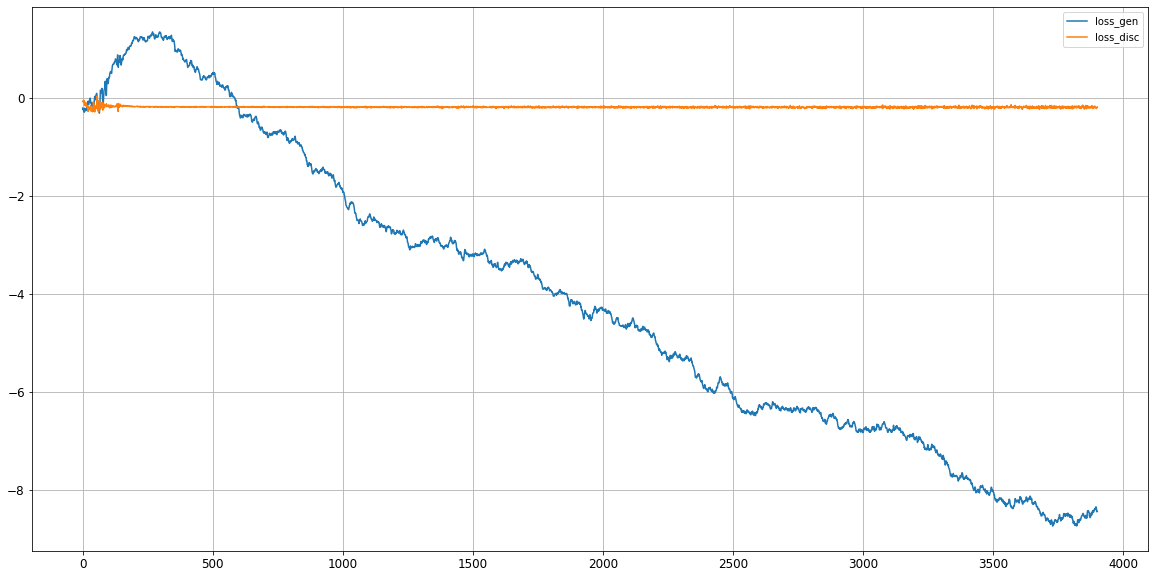

Epoch 4001/10000
critic: -0.197169 - generator: -8.433450 - 2s
disc_numpy -0.13724516
gen_numpy -8.425956
Epoch 4002/10000
critic: -0.182433 - generator: -8.410069 - 2s
disc_numpy -0.2199387
gen_numpy -8.458574
Epoch 4003/10000
critic: -0.187718 - generator: -8.392662 - 2s
disc_numpy -0.15124887
gen_numpy -8.373716
Epoch 4004/10000
critic: -0.188812 - generator: -8.431083 - 2s
disc_numpy -0.22845858
gen_numpy -8.544598
Epoch 4005/10000
critic: -0.199302 - generator: -8.442040 - 2s
disc_numpy -0.17355582
gen_numpy -8.402496
Epoch 4006/10000
critic: -0.163911 - generator: -8.454643 - 2s
disc_numpy -0.10975537
gen_numpy -8.585572
Epoch 4007/10000
critic: -0.202924 - generator: -8.467669 - 2s
disc_numpy -0.32006007
gen_numpy -8.550272
Epoch 4008/10000
critic: -0.198407 - generator: -8.491901 - 2s
disc_numpy -0.18611567
gen_numpy -8.529231
Epoch 4009/10000
critic: -0.188629 - generator: -8.527582 - 2s
disc_numpy -0.12874267
gen_numpy -8.652962
Epoch 4010/10000
critic: -0.171584 - generator:

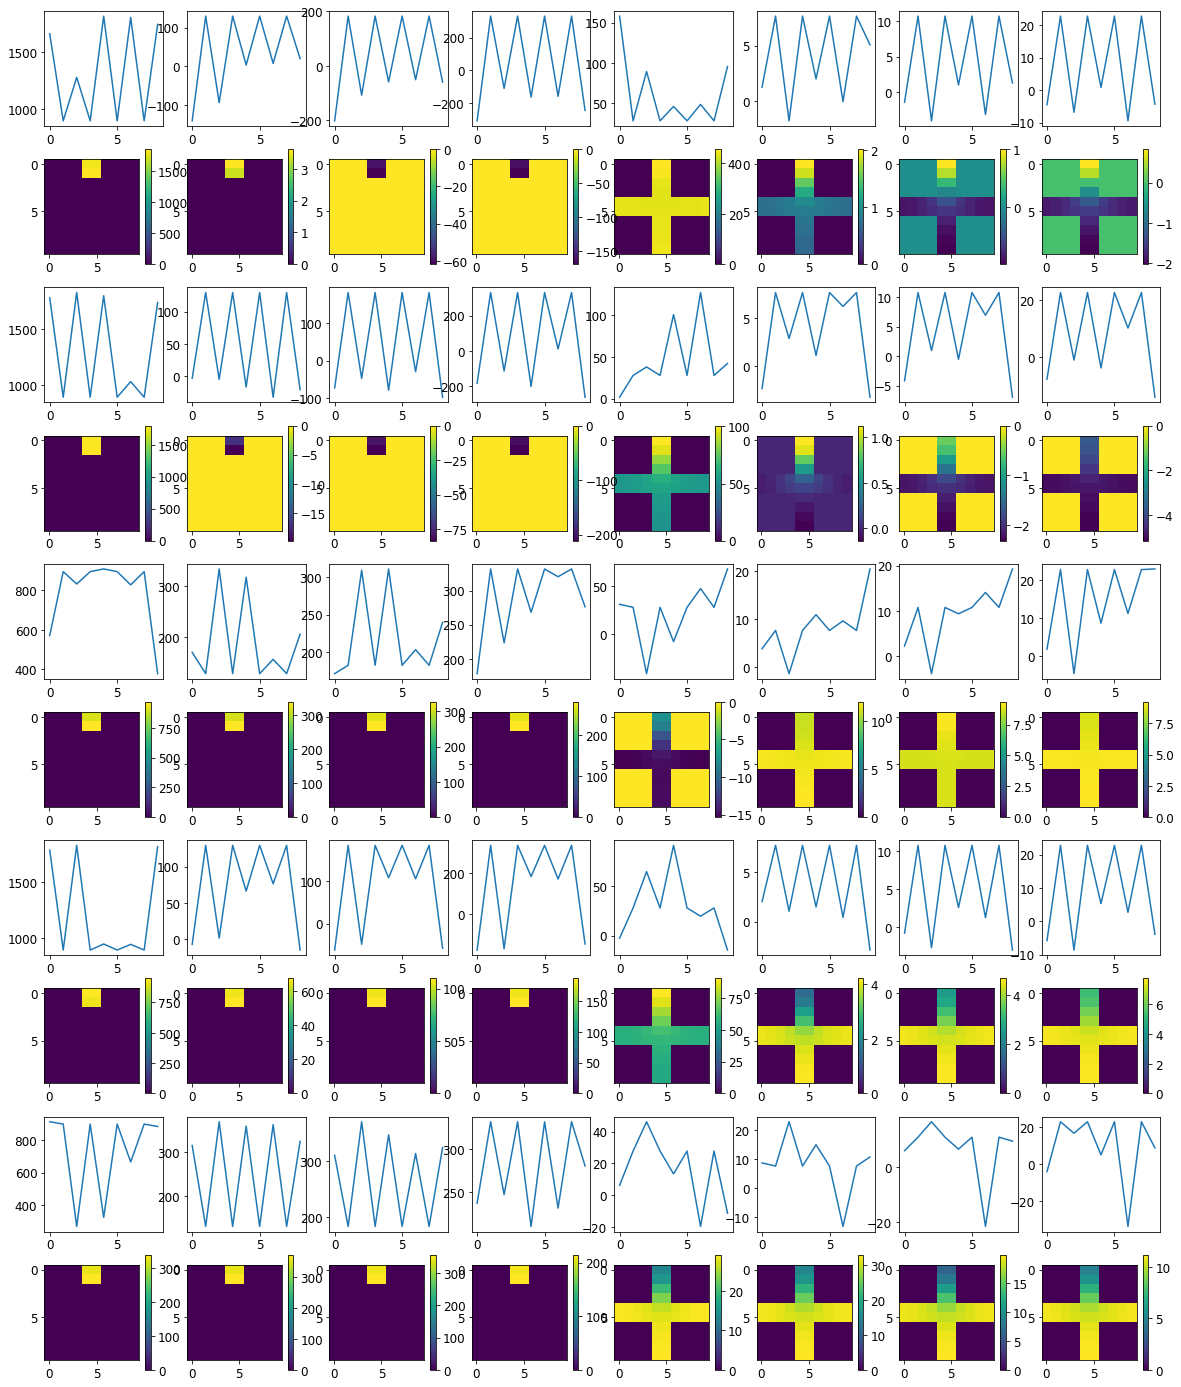

Loss: 


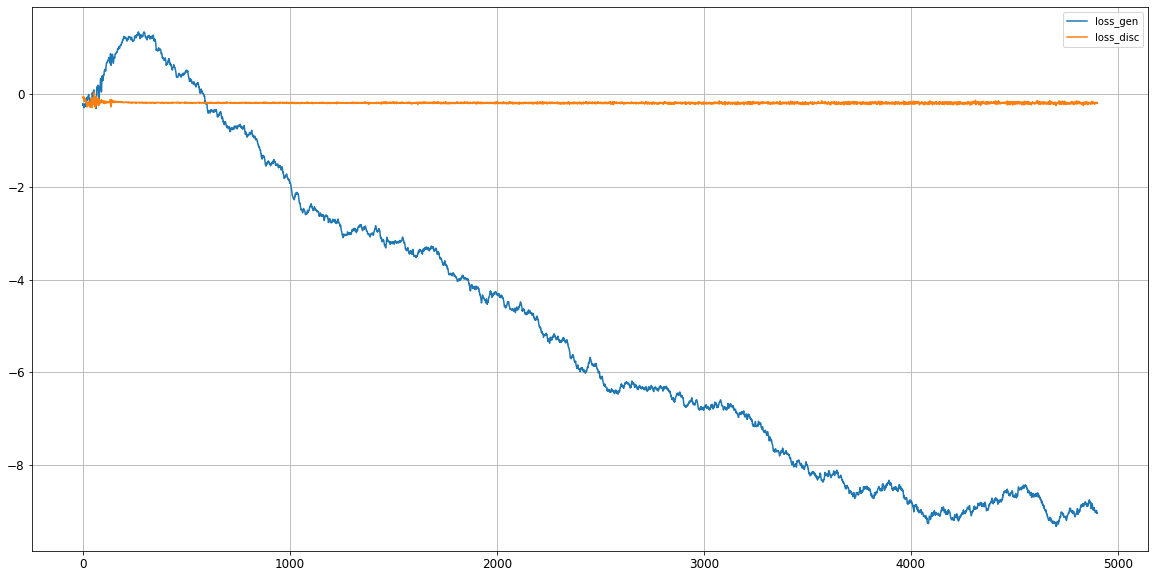

Epoch 5001/10000
critic: -0.151759 - generator: -9.039063 - 2s
disc_numpy -0.090976335
gen_numpy -8.987813
Epoch 5002/10000
critic: -0.184005 - generator: -9.065303 - 2s
disc_numpy -0.19006497
gen_numpy -8.94519
Epoch 5003/10000
critic: -0.160058 - generator: -9.088681 - 2s
disc_numpy 0.003017839
gen_numpy -9.1908655
Epoch 5004/10000
critic: -0.213857 - generator: -9.094919 - 2s
disc_numpy -0.20699425
gen_numpy -9.10119
Epoch 5005/10000
critic: -0.180772 - generator: -9.092867 - 2s
disc_numpy -0.07409565
gen_numpy -9.102257
Epoch 5006/10000
critic: -0.161928 - generator: -9.114651 - 2s
disc_numpy -0.24377519
gen_numpy -9.130362
Epoch 5007/10000
critic: -0.175657 - generator: -9.087388 - 2s
disc_numpy -0.15479308
gen_numpy -9.132183
Epoch 5008/10000
critic: -0.196706 - generator: -9.055793 - 2s
disc_numpy -0.2455913
gen_numpy -9.09491
Epoch 5009/10000
critic: -0.161014 - generator: -9.069948 - 2s
disc_numpy -0.116318956
gen_numpy -9.112233
Epoch 5010/10000
critic: -0.171507 - generator:

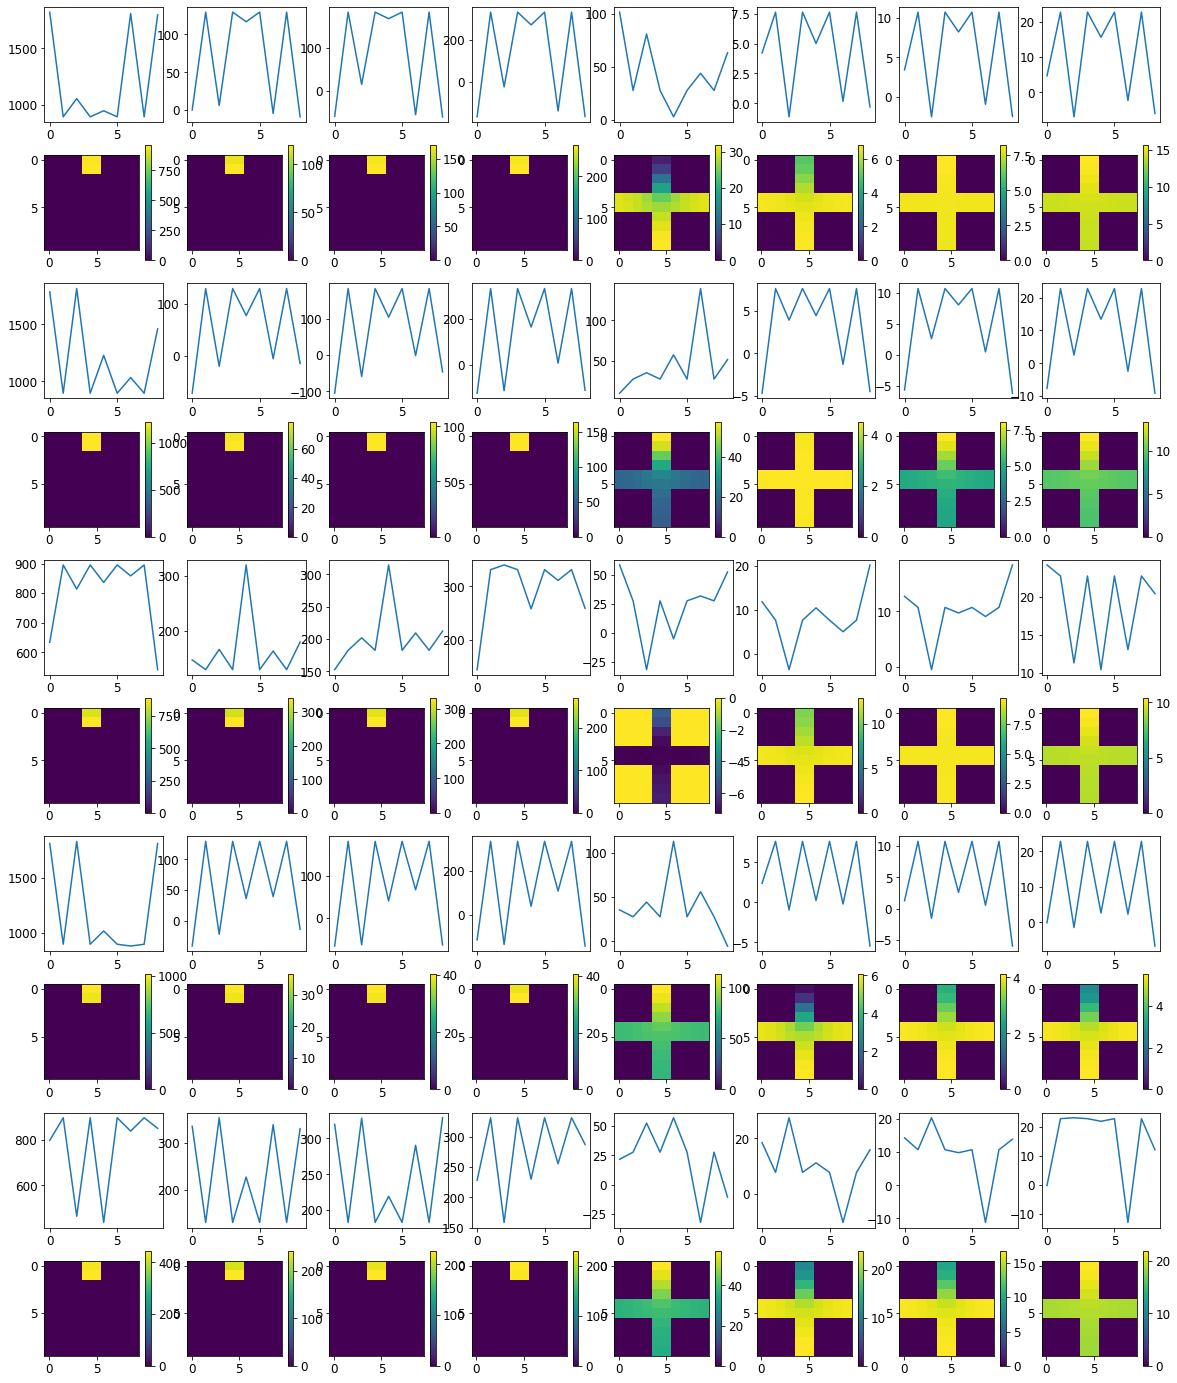

Loss: 


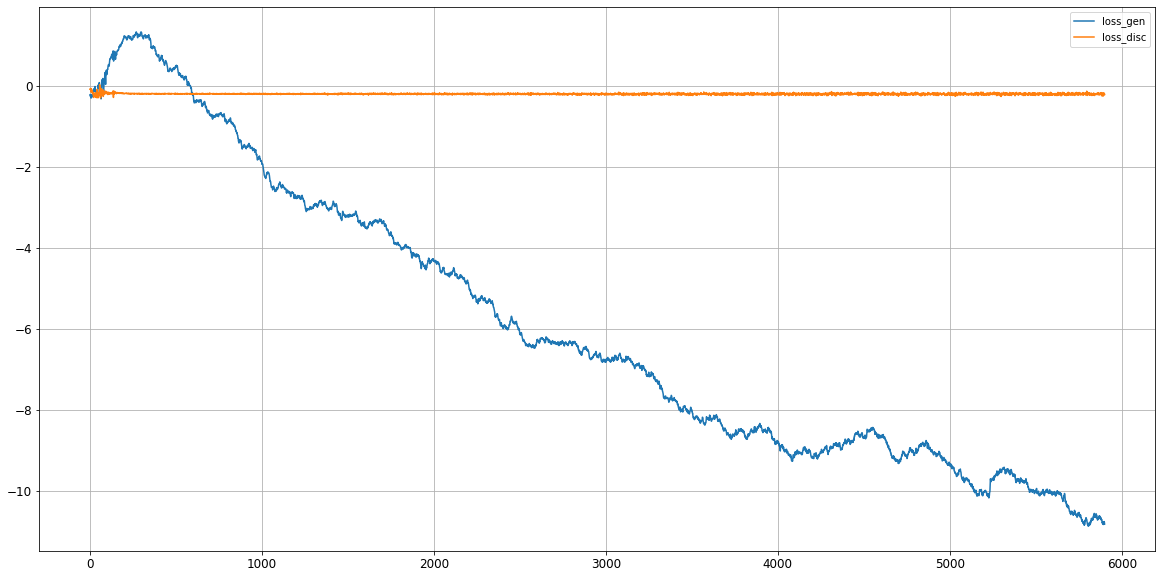

Epoch 6001/10000
critic: -0.206886 - generator: -10.842747 - 2s
disc_numpy -0.19868967
gen_numpy -10.809107
Epoch 6002/10000
critic: -0.167053 - generator: -10.843018 - 2s
disc_numpy -0.039645158
gen_numpy -11.009383
Epoch 6003/10000
critic: -0.182951 - generator: -10.918219 - 2s
disc_numpy -0.10202451
gen_numpy -10.952596
Epoch 6004/10000
critic: -0.186098 - generator: -10.928493 - 2s
disc_numpy -0.23002864
gen_numpy -10.980253
Epoch 6005/10000
critic: -0.180373 - generator: -10.900137 - 2s
disc_numpy -0.19639401
gen_numpy -10.836989
Epoch 6006/10000
critic: -0.207716 - generator: -10.880968 - 2s
disc_numpy -0.24228281
gen_numpy -10.8386965
Epoch 6007/10000
critic: -0.192822 - generator: -10.872991 - 2s
disc_numpy -0.21593422
gen_numpy -10.908203
Epoch 6008/10000
critic: -0.182973 - generator: -10.850236 - 2s
disc_numpy -0.2126568
gen_numpy -10.842447
Epoch 6009/10000
critic: -0.186473 - generator: -10.916837 - 2s
disc_numpy -0.03231003
gen_numpy -10.908448
Epoch 6010/10000
critic: -0

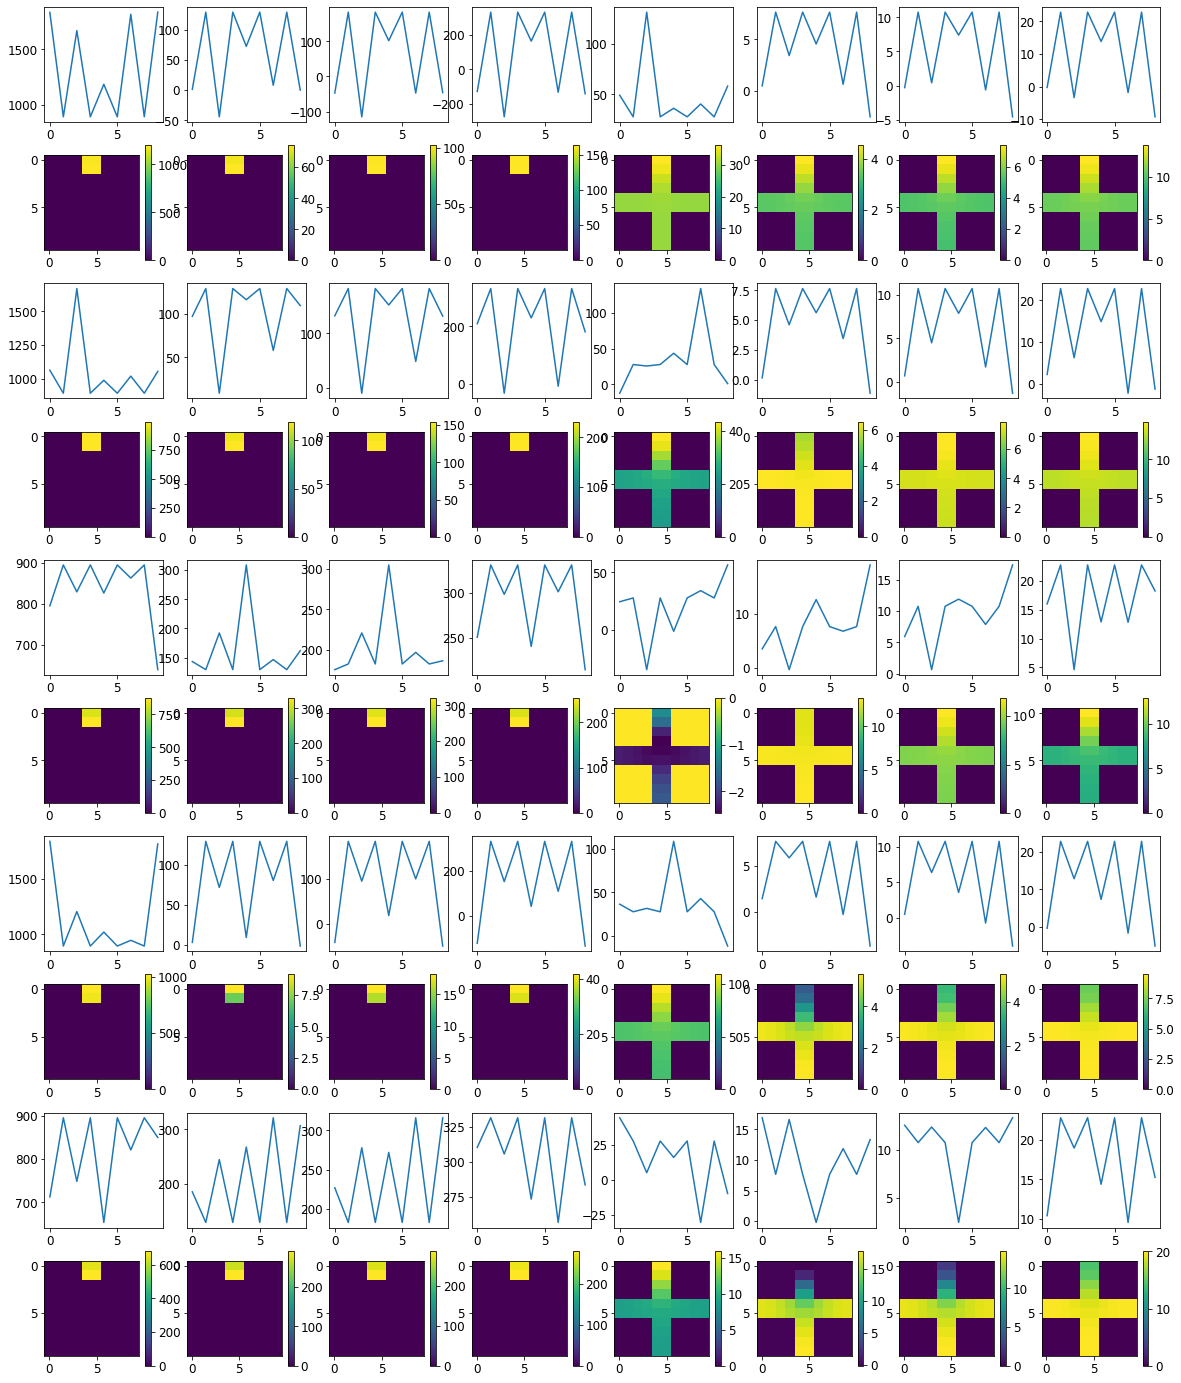

Loss: 


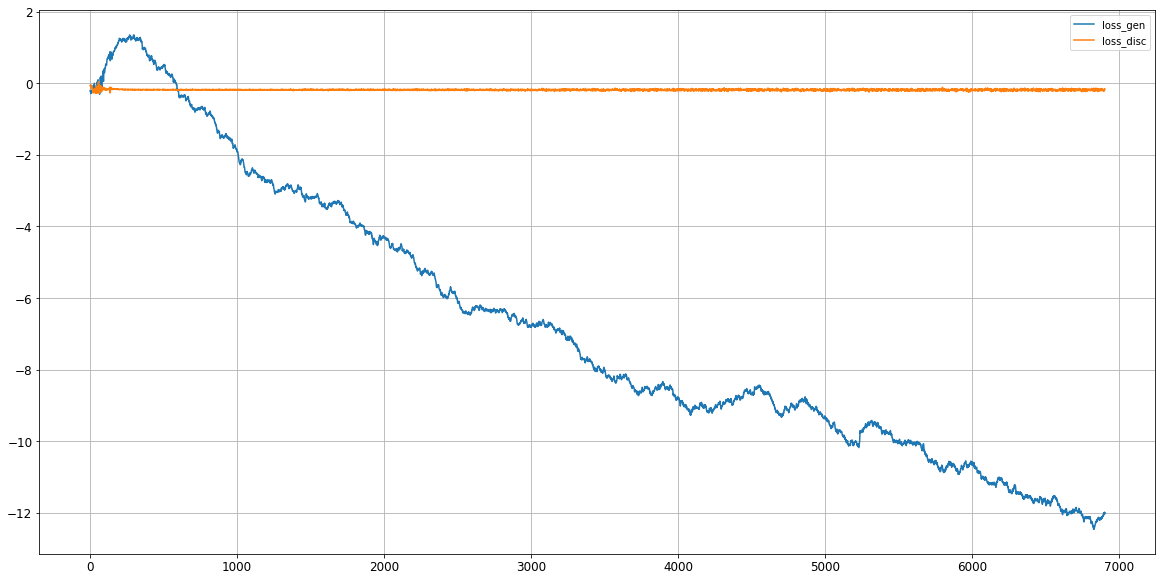

Epoch 7001/10000
critic: -0.217894 - generator: -12.016195 - 2s
disc_numpy -0.21589759
gen_numpy -12.013941
Epoch 7002/10000
critic: -0.186933 - generator: -11.994445 - 2s
disc_numpy -0.27647492
gen_numpy -12.011045
Epoch 7003/10000
critic: -0.179275 - generator: -11.984296 - 2s
disc_numpy -0.1945069
gen_numpy -12.082026
Epoch 7004/10000
critic: -0.198394 - generator: -12.073510 - 2s
disc_numpy -0.02707123
gen_numpy -12.053083
Epoch 7005/10000
critic: -0.186250 - generator: -12.052552 - 2s
disc_numpy -0.25558844
gen_numpy -12.0830555
Epoch 7006/10000
critic: -0.223335 - generator: -12.057833 - 2s
disc_numpy -0.15642497
gen_numpy -12.012682
Epoch 7007/10000
critic: -0.181981 - generator: -12.040261 - 2s
disc_numpy -0.15085661
gen_numpy -12.044328
Epoch 7008/10000
critic: -0.209238 - generator: -12.080884 - 2s
disc_numpy -0.087880746
gen_numpy -12.058914
Epoch 7009/10000
critic: -0.229272 - generator: -12.105386 - 2s
disc_numpy -0.22013345
gen_numpy -12.170525
Epoch 7010/10000
critic: -0

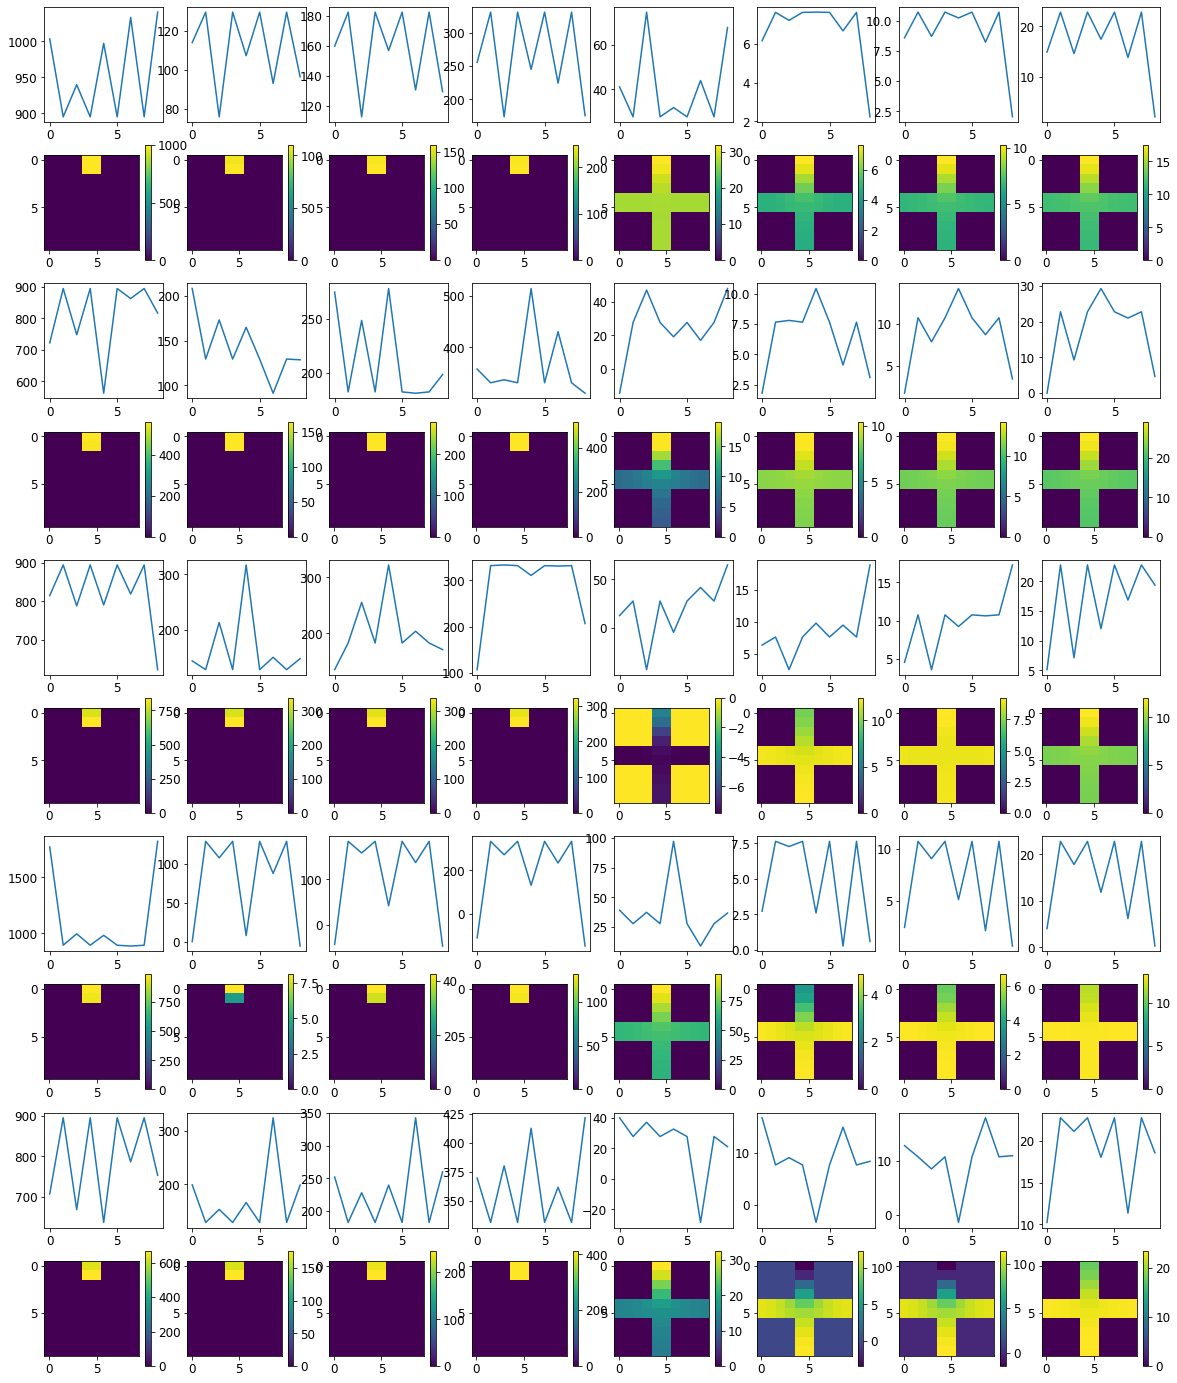

Loss: 


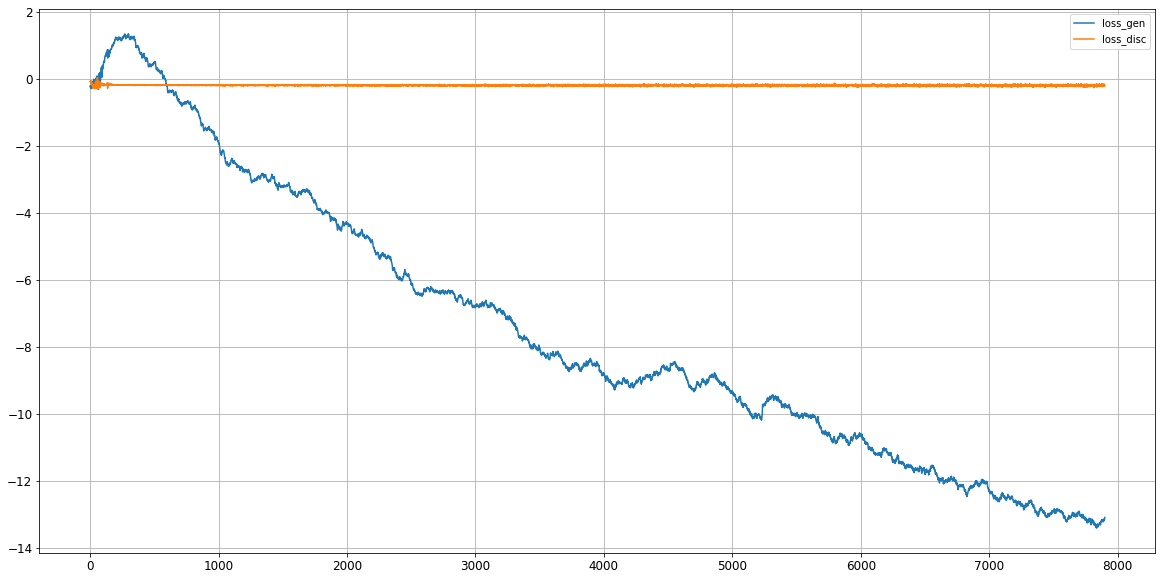

Epoch 8001/10000
critic: -0.201520 - generator: -13.167554 - 2s
disc_numpy -0.26265574
gen_numpy -13.093953
Epoch 8002/10000
critic: -0.191713 - generator: -13.136185 - 2s
disc_numpy -0.17162481
gen_numpy -13.299031
Epoch 8003/10000
critic: -0.230459 - generator: -13.120898 - 2s
disc_numpy -0.17063266
gen_numpy -13.202186
Epoch 8004/10000
critic: -0.194157 - generator: -13.086504 - 2s
disc_numpy -0.041775286
gen_numpy -13.10444
Epoch 8005/10000
critic: -0.168929 - generator: -13.098893 - 2s
disc_numpy -0.25440025
gen_numpy -13.098638
Epoch 8006/10000
critic: -0.201751 - generator: -13.144251 - 2s
disc_numpy -0.13075456
gen_numpy -13.185071
Epoch 8007/10000
critic: -0.184192 - generator: -13.151096 - 2s
disc_numpy -0.020701608
gen_numpy -13.139862
Epoch 8008/10000
critic: -0.183598 - generator: -13.097102 - 2s
disc_numpy -0.15108065
gen_numpy -13.056028
Epoch 8009/10000
critic: -0.195045 - generator: -13.097735 - 2s
disc_numpy -0.02324935
gen_numpy -13.03707
Epoch 8010/10000
critic: -0.

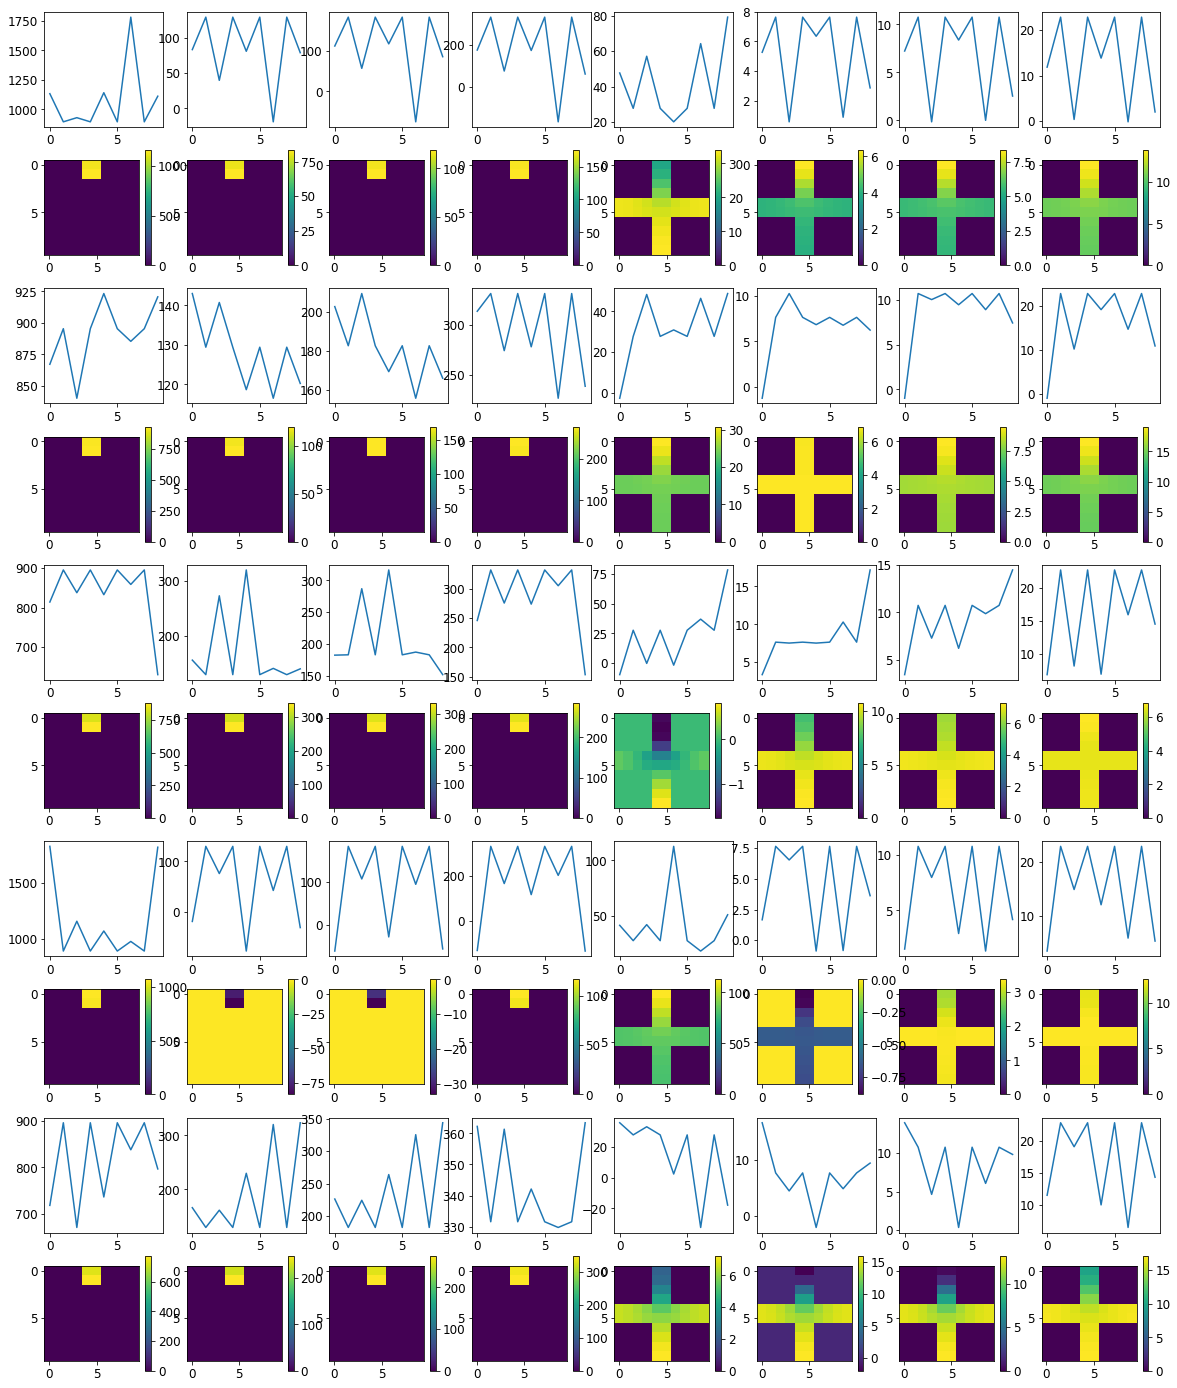

Loss: 


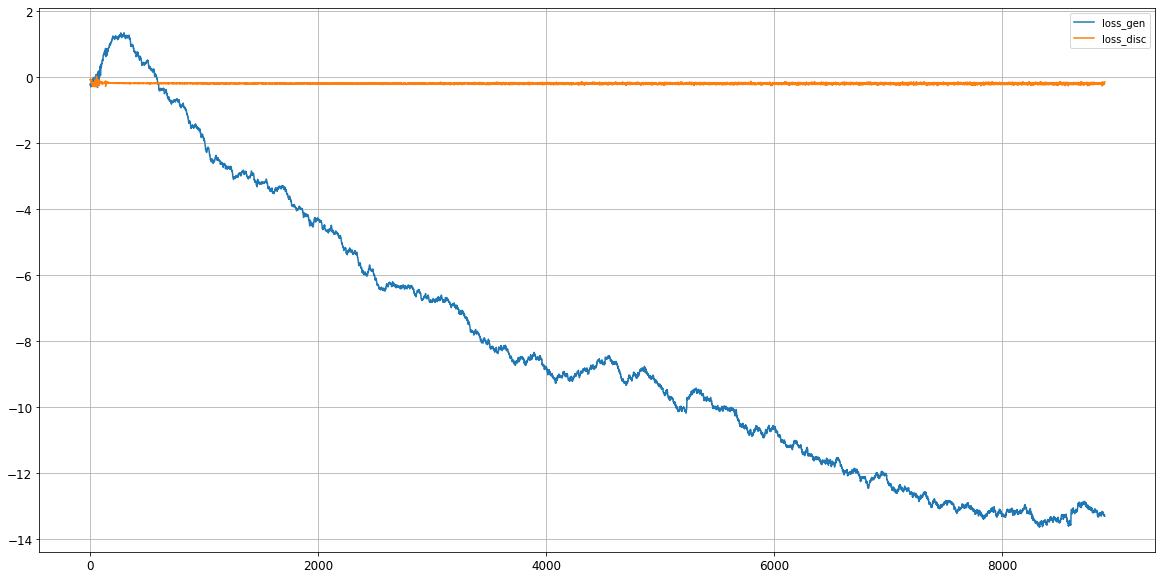

Epoch 9001/10000
critic: -0.196925 - generator: -13.256306 - 2s
disc_numpy -0.26855356
gen_numpy -13.381271
Epoch 9002/10000
critic: -0.190689 - generator: -13.237765 - 2s
disc_numpy -0.07291196
gen_numpy -13.218721
Epoch 9003/10000
critic: -0.195250 - generator: -13.245328 - 2s
disc_numpy -0.129617
gen_numpy -13.230422
Epoch 9004/10000
critic: -0.193171 - generator: -13.227408 - 2s
disc_numpy -0.19889967
gen_numpy -13.248132
Epoch 9005/10000
critic: -0.186781 - generator: -13.216319 - 2s
disc_numpy -0.18875432
gen_numpy -13.256699
Epoch 9006/10000
critic: -0.126353 - generator: -13.188722 - 2s
disc_numpy -0.16474445
gen_numpy -13.101948
Epoch 9007/10000
critic: -0.193904 - generator: -13.150369 - 2s
disc_numpy -0.345894
gen_numpy -13.226414
Epoch 9008/10000
critic: -0.178932 - generator: -13.177265 - 2s
disc_numpy -0.3658719
gen_numpy -13.23592
Epoch 9009/10000
critic: -0.185059 - generator: -13.185381 - 2s
disc_numpy -0.14048727
gen_numpy -13.28029
Epoch 9010/10000
critic: -0.187701 

In [36]:
hist = train(train_dataset, epochs=10000)

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


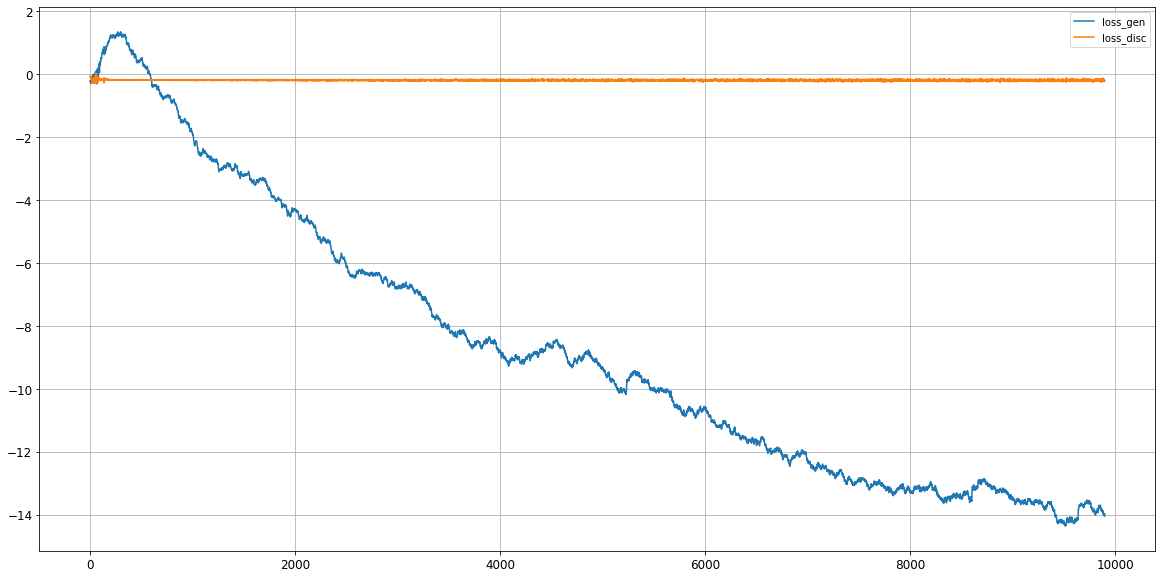

In [38]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(hist[100:])
ax.legend(['loss_gen', 'loss_disc'])
#ax.set_yscale('log')
ax.grid()

In [40]:
#from tensorflow.keras.models import load_model
import joblib
joblib.dump(scaler, "scaler-tfex.pkl")
wgan.save("wgan-tfex.h5")

In [42]:
np.random.seed(10)
tf.random.set_seed(10)

noise = tf.random.normal(shape=[1, latent_space])
X_generated = scaler.inverse_transform((wgan.layers[0].predict(noise).reshape(ntimes,15)+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated[X_generated<0.0] = 0.0

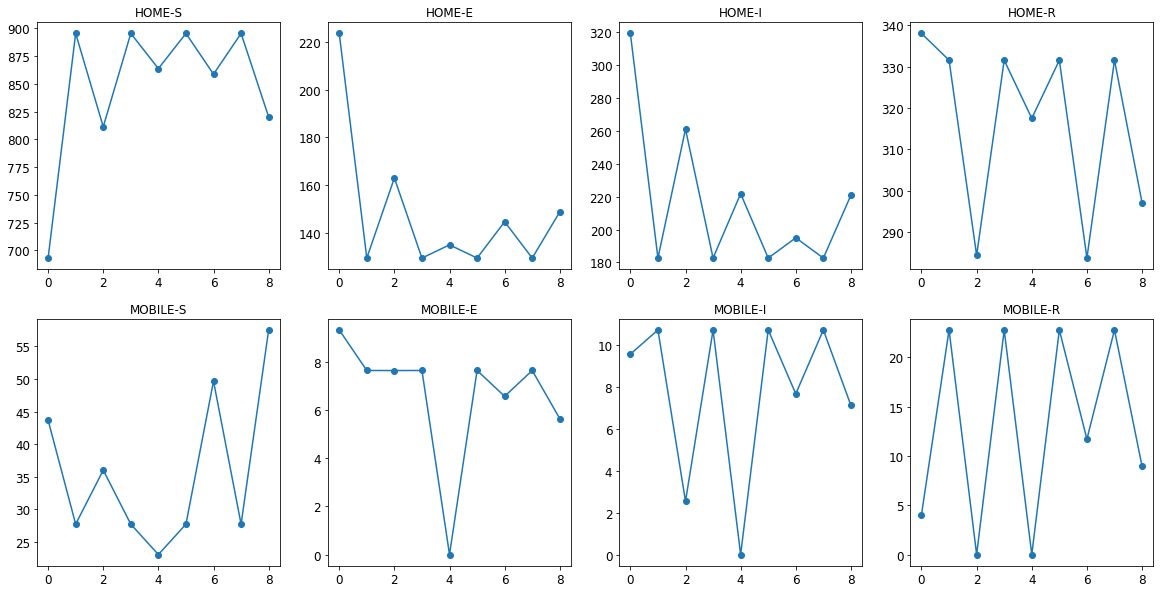

In [43]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:,i*nl*nc+4], '-o')
    ax.flatten()[i].set_title(group)

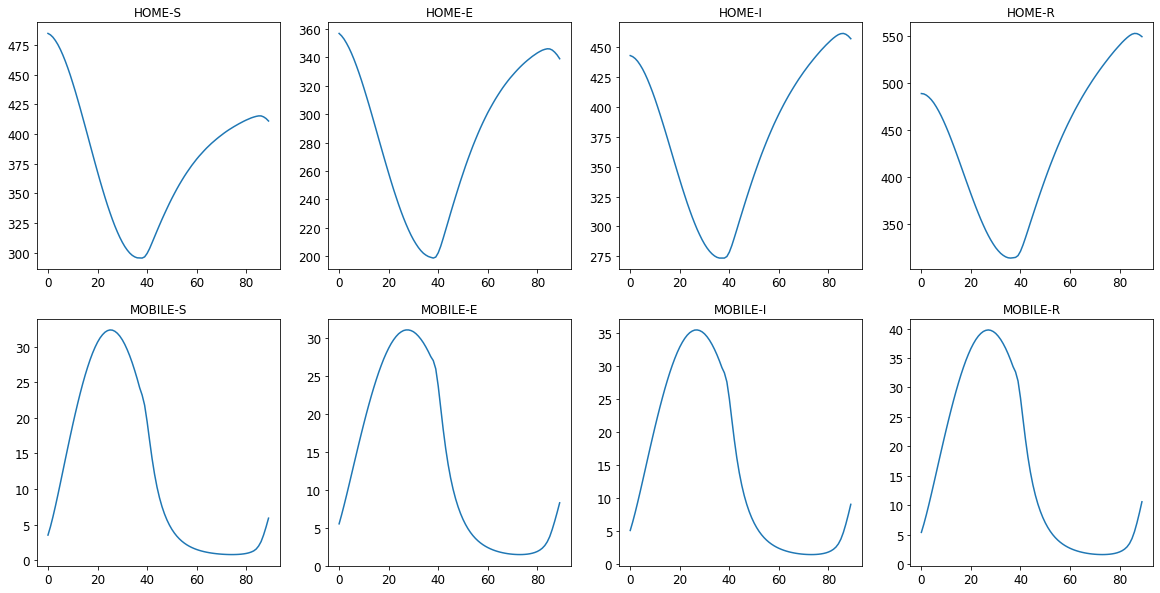

In [44]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train_1D[2930:3020,i*nl*nc+4])
    ax.flatten()[i].set_title(group)

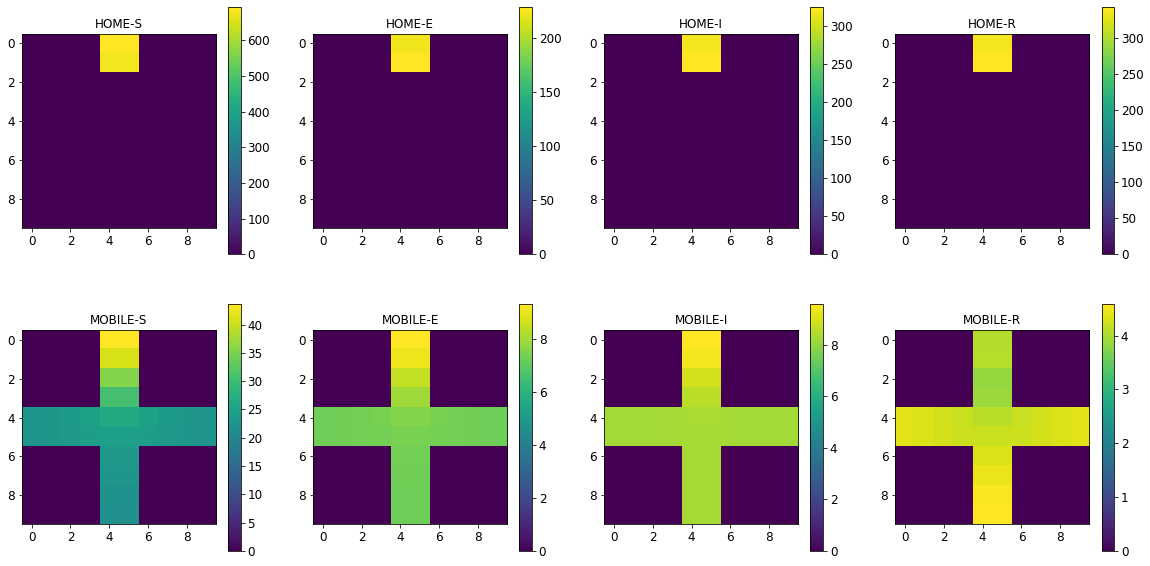

In [45]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_generated.reshape(ntimes,len(groups),nl,nc)[0,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

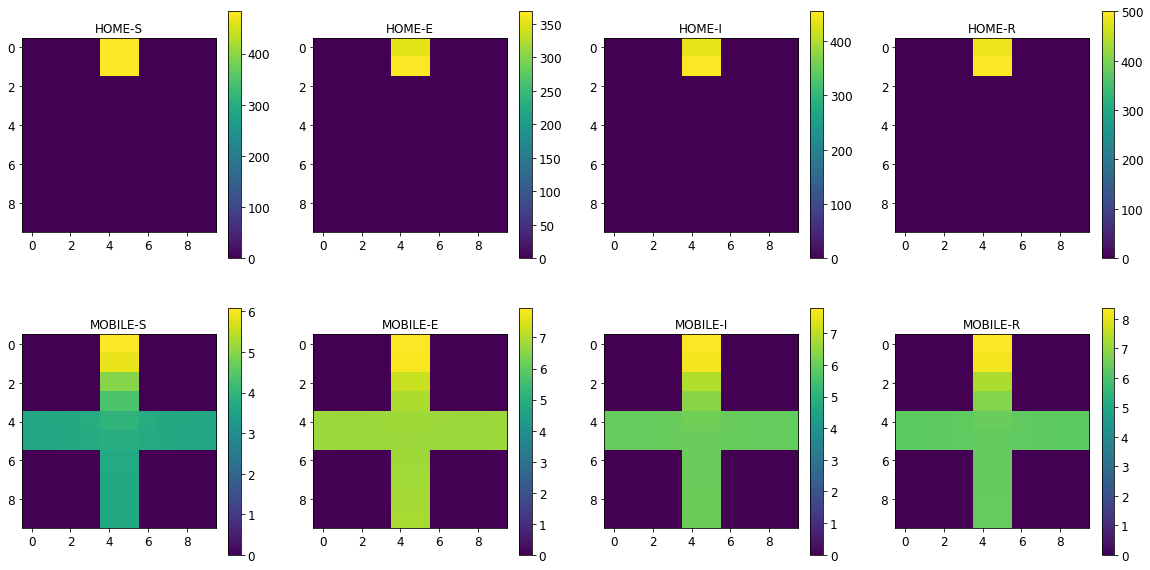

In [46]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_train_1D.reshape(len(times),len(groups),nl,nc)[2932,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

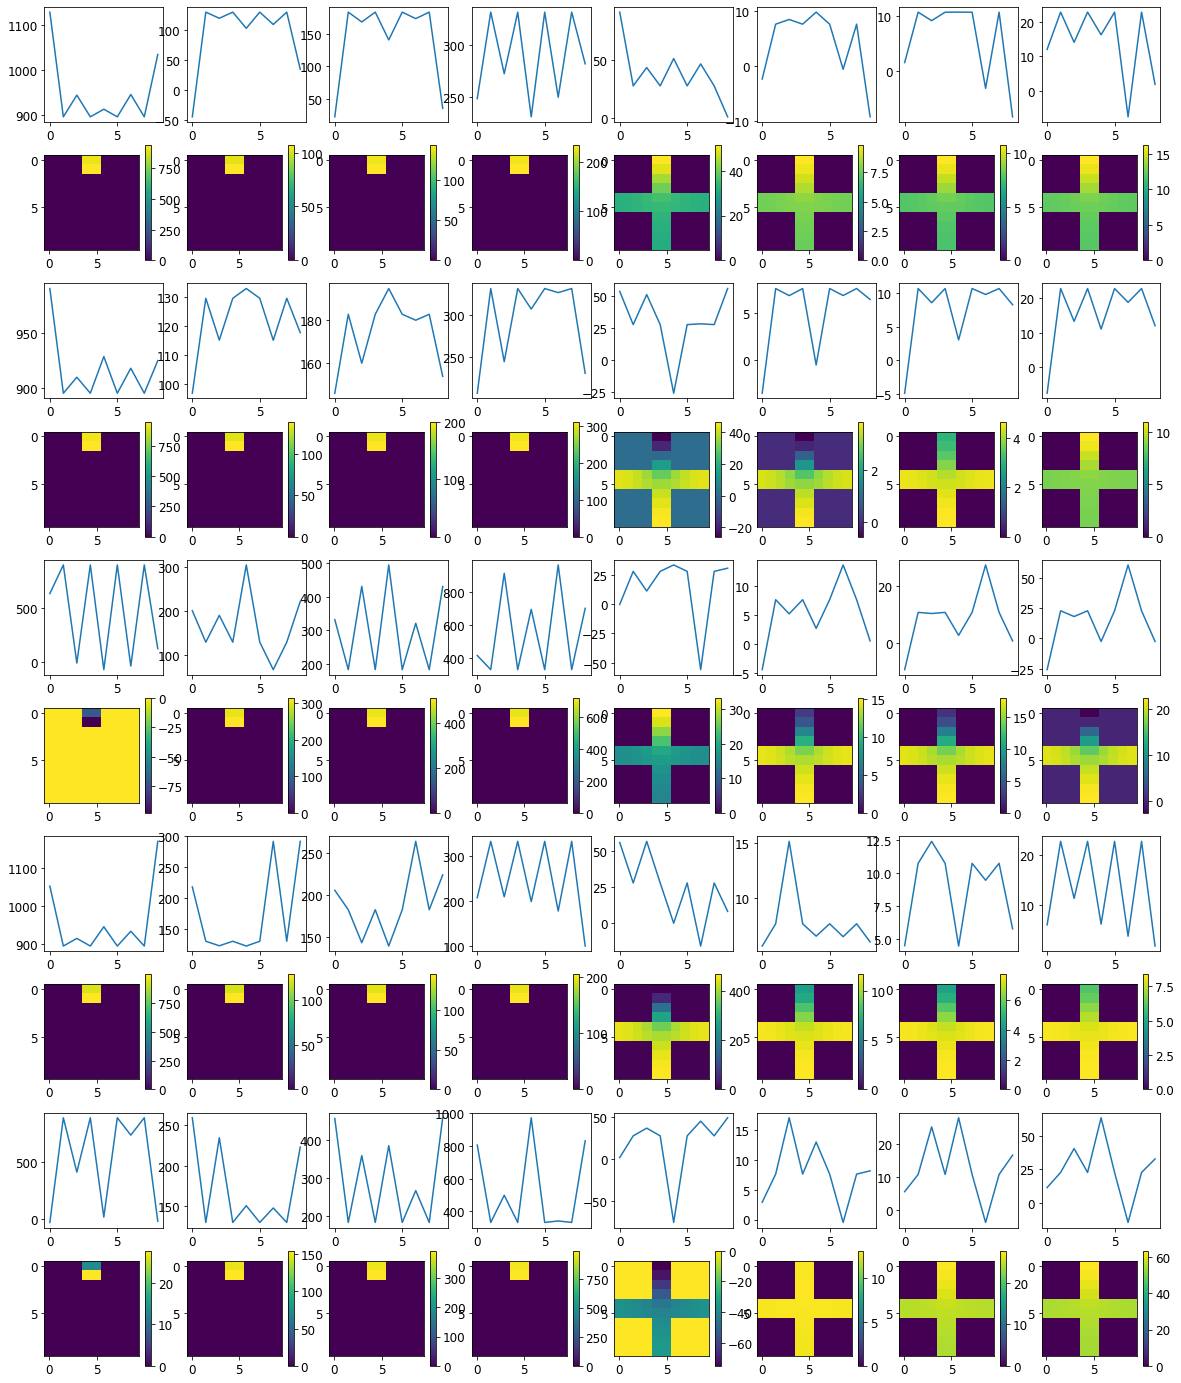

In [48]:
npredict = 5
noise = tf.random.normal(shape=[npredict, latent_space])
X_generated = scaler.inverse_transform((wgan.layers[0].predict(noise).reshape(npredict*ntimes,15)+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated = X_generated.reshape(npredict, ntimes, len(groups)*nl*nc)
fig, ax = plt.subplots(npredict*2,len(groups), figsize=[20,npredict*5])
for j in range(npredict):
    for i, group in enumerate(groups):
        for k in range(0,10,10): 
            ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
    for i, group in enumerate(groups):
        im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
        fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])
